## LATIHAN ARIMA-TRANSFORMER

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm, shapiro, anderson
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest

In [2]:
import tensorflow as tf
import keras

print(tf.__version__, keras.__version__)

2.18.0 3.8.0


In [3]:
data_df = pd.read_excel('QBO Data.xlsx')
columns_name = ['25 hPa']
Data = pd.DataFrame(data_df, columns=columns_name)
time_series_numpy = Data.values.astype(float)  # Replace 'your_column_name' with the actual column name

# Seasonal features (assuming you have a time index)
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%d%m%Y')
data_df.set_index('Date', inplace=True)

In [4]:
print(data_df.columns)

Index(['30 hPa', '25 hPa', '20 hPa'], dtype='object')


In [5]:
Data.tail()

,25 hPa
414,-297
415,-319
416,-332
417,-339
418,-320


In [6]:
def add_lag_features(data_df, lags):
    for lag in lags:
        column_name_lag = f'lag_{lag}'
        data_df[column_name_lag] = data_df['25 hPa'].shift(lag)

def add_rolling_statistics(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_min = f'rolling_min_{window_size}'
        column_name_max = f'rolling_max_{window_size}'
        column_name_ma = f'moving_average_{window_size}'
        column_name_ema = f'ema_{window_size}'
        column_name_std = f'moving_std_{window_size}'
        column_name_median = f'moving_median_{window_size}'

        data_df[column_name_min] = data_df['25 hPa'].rolling(window=window_size).min()
        data_df[column_name_max] = data_df['25 hPa'].rolling(window=window_size).max()
        data_df[column_name_ma] = data_df['25 hPa'].rolling(window=window_size).mean()
        data_df[column_name_ema] = data_df['25 hPa'].ewm(span=window_size, adjust=False).mean()
        data_df[column_name_std] = data_df['25 hPa'].rolling(window=window_size).std()
        data_df[column_name_median] = data_df['25 hPa'].rolling(window=window_size).median()

def add_interaction_features(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_interaction = f'interaction_ma_ema_{window_size}'
        data_df[column_name_interaction] = data_df[f'moving_average_{window_size}'] * data_df[f'ema_{window_size}']

def add_seasonal_features(data_df):
    data_df['quarter'] = data_df.index.quarter
    data_df['year'] = data_df.index.year

def add_rate_of_change(data_df, lags):
    for lag in lags:
        column_name_roc = f'roc_{lag}'
        data_df[column_name_roc] = (data_df['25 hPa'] - data_df['25 hPa'].shift(lag)) / data_df['25 hPa'].shift(lag)

def add_cumulative_sum(data_df):
    data_df['cumulative_sum'] = data_df['25 hPa'].cumsum()

def add_ewma_std(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_ewma_std = f'ewma_std_{window_size}'
        data_df[column_name_ewma_std] = data_df['25 hPa'].ewm(span=window_size, adjust=False).std()

def add_additional_statistics(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_lagged_ma = f'lagged_ma_{window_size}'
        column_name_lagged_ema = f'lagged_ema_{window_size}'
        column_name_acf = f'autocorr_{window_size}'

        data_df[column_name_lagged_ma] = data_df[f'moving_average_{window_size}'].shift(1)
        data_df[column_name_lagged_ema] = data_df[f'ema_{window_size}'].shift(1)
        data_df[column_name_acf] = data_df['25 hPa'].autocorr(lag=window_size)

def add_z_scores(data_df):
    # Z-Score based on standard deviation
    data_df['z_score'] = (data_df['25 hPa'] - data_df['25 hPa'].mean()) / data_df['25 hPa'].std()

    # Z-Score based on median and median absolute deviation (MAD)
    median = data_df['25 hPa'].median()
    mad = np.median(np.abs(data_df['25 hPa'] - median))
    data_df['mad_z_score'] = (data_df['25 hPa'] - median) / mad

def add_log_returns(data_df):
    data_df['log_returns'] = np.log(data_df['25 hPa'] / data_df['25 hPa'].shift(1))


# List of lags for lag features
lags = [1, 2, 3]
# Lags represent the time intervals used to shift and create lag features, capturing historical values at different points in the past.

# List of window sizes for rolling statistics and other features
window_sizes = [2, 3, 12, 24, 28, 36]
# Window sizes determine the size of the rolling windows used for calculating statistics and features. Different sizes capture varying trends and patterns over specified periods.


add_lag_features(data_df, lags)
add_rolling_statistics(data_df, window_sizes)
add_interaction_features(data_df, window_sizes)
add_seasonal_features(data_df)
add_rate_of_change(data_df, lags)
add_cumulative_sum(data_df)
add_ewma_std(data_df, window_sizes)
add_additional_statistics(data_df, window_sizes)
add_z_scores(data_df)
add_log_returns(data_df)

data_df_drop = data_df.dropna()

In [7]:
data_df_drop.head()

,30 hPa,25 hPa,20 hPa,lag_1,lag_2,lag_3,rolling_min_2,rolling_max_2,moving_average_2,ema_2,...,autocorr_24,lagged_ma_28,lagged_ema_28,autocorr_28,lagged_ma_36,lagged_ema_36,autocorr_36,z_score,mad_z_score,log_returns
Date,,,,,,,,,,,,,,,,,,,,,
1990-02-10,-32,79,146,64.0,-147.0,-297.0,64.0,79.0,71.5,44.784972,...,0.297326,-161.178571,-204.733321,0.497812,-154.111111,-203.339901,-0.063237,0.806582,0.635359,0.210565
1990-03-10,109,177,181,79.0,64.0,-147.0,79.0,177.0,128.0,132.928324,...,0.297326,-162.928571,-185.165506,0.497812,-144.138889,-188.078285,-0.063237,1.311036,1.176796,0.806702
1990-04-10,124,152,166,177.0,79.0,64.0,152.0,177.0,164.5,145.642775,...,0.297326,-159.928571,-160.188575,0.497812,-130.638889,-168.344324,-0.063237,1.182349,1.038674,-0.152269
1990-05-10,124,160,136,152.0,177.0,79.0,152.0,160.0,156.0,155.214258,...,0.297326,-156.571429,-138.658328,0.497812,-118.000000,-151.028414,-0.063237,1.223529,1.082873,0.051293
1990-06-10,152,185,172,160.0,152.0,177.0,160.0,185.0,172.5,175.071419,...,0.297326,-153.000000,-118.061202,0.497812,-105.527778,-134.216068,-0.063237,1.352216,1.220994,0.145182


In [8]:
data_df_drop.tail()

,30 hPa,25 hPa,20 hPa,lag_1,lag_2,lag_3,rolling_min_2,rolling_max_2,moving_average_2,ema_2,...,autocorr_24,lagged_ma_28,lagged_ema_28,autocorr_28,lagged_ma_36,lagged_ema_36,autocorr_36,z_score,mad_z_score,log_returns
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-10,-238,-297,-316,-258.0,-167.0,-40.0,-297.0,-258.0,-277.5,-267.733977,...,0.297326,38.000000,1.511001,0.497812,37.638889,-0.392901,-0.063237,-1.128871,-1.441989,0.140773
2021-08-10,-233,-319,-330,-297.0,-258.0,-167.0,-319.0,-297.0,-308.0,-301.911326,...,0.297326,21.357143,-19.075964,0.497812,39.055556,-16.425717,-0.063237,-1.242116,-1.563536,0.071459
2021-09-10,-268,-332,-359,-319.0,-297.0,-258.0,-332.0,-319.0,-325.5,-321.970442,...,0.297326,4.500000,-39.760381,0.497812,33.222222,-32.781083,-0.063237,-1.309033,-1.635359,0.039944
2021-10-01,-283,-339,-368,-332.0,-319.0,-297.0,-339.0,-332.0,-335.5,-333.323481,...,0.297326,-13.285714,-59.914837,0.497812,22.694444,-48.955079,-0.063237,-1.345066,-1.674033,0.020865
2021-01-11,-279,-320,-351,-339.0,-332.0,-319.0,-339.0,-320.0,-329.5,-324.441160,...,0.297326,-29.785714,-79.162090,0.497812,10.027778,-64.633183,-0.063237,-1.247264,-1.569061,-0.057679


In [9]:
# Convert DataFrame to NumPy array
features_array = data_df_drop.to_numpy()

# Create input and output dataframes
input_data = pd.DataFrame(data_df_drop, columns=data_df.columns)
input_data1 = input_data.iloc[:-1, :]
output_data = input_data.iloc[1:, 0]

# Convert to NumPy arrays
features = input_data1.to_numpy()
target = output_data.to_numpy()

# Standardize features
feature_scaler = StandardScaler()
features_scaled = feature_scaler.fit_transform(features)

# Standardize target variable
target_scaler = StandardScaler()
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))

In [10]:
def feature_metrics(features, target):
    # 1. F-statistic (ANOVA)
    f_stat, p_values_anova = f_regression(features, target)

    # 2. Random Forest Feature Importance
    rf_model = RandomForestRegressor()
    rf_model.fit(features, target)
    rf_feature_importances = rf_model.feature_importances_

    # 3. Mutual Information
    mutual_info_scores = mutual_info_regression(features, target)

    # 4. Principal Component Analysis (PCA)
    pca = PCA()
    pca.fit(features)
    explained_variance_ratio = pca.explained_variance_ratio_

    # Return the selected features based on each method
    selected_features = {
        'f_stat': f_stat,
        'rf_feature_importances': rf_feature_importances,
        'mutual_info_scores': mutual_info_scores,
        'explained_variance_ratio': explained_variance_ratio,
        }

    return selected_features

In [11]:
def rank_and_top_features(scores, top_n=10):
    # Create a new dataframe for ranks
    ranks_df = pd.DataFrame()

    # Assign the ranking for each method
    for col in scores.columns:
        ranks_df[col+'_rank'] = scores[col].rank(ascending=False)

    # Calculate mean rank for each feature
    ranks_df['mean_rank'] = ranks_df.mean(axis=1)

    # Identify the top features based on mean rank
    top_features_index = ranks_df.nsmallest(top_n, 'mean_rank').index

    return ranks_df, top_features_index


Top 20 Features Index:
Index(['25 hPa', '30 hPa', 'ema_2', 'rolling_max_2', '20 hPa',
       'moving_average_2', 'lag_1', 'rolling_min_3', 'moving_median_2',
       'ema_3', 'rolling_min_2', 'mad_z_score', 'z_score', 'ema_12',
       'interaction_ma_ema_2', 'moving_average_3', 'rolling_max_3', 'lag_3',
       'lag_2', 'interaction_ma_ema_3'],
      dtype='object')


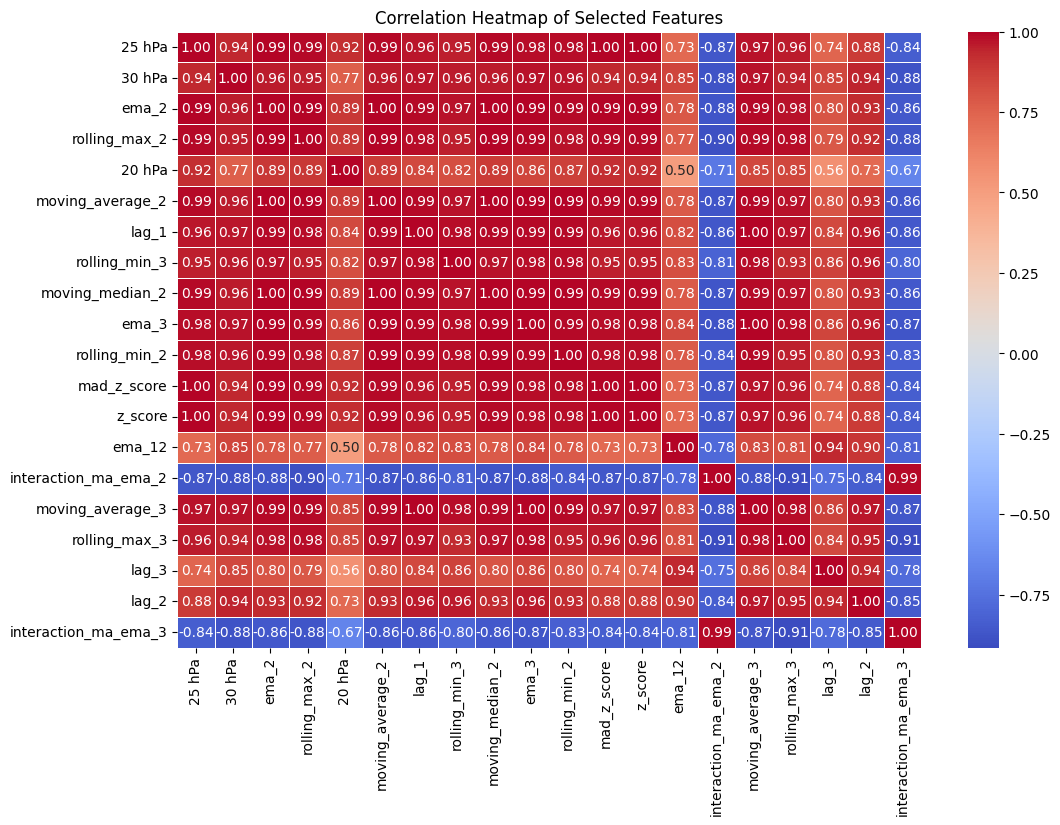

In [12]:
# Calculate and rank features
scores = feature_metrics(features_scaled, scaled_target)
df_scores = pd.DataFrame(scores)
top_n = 20  # Change this to the desired value

# Get ranked scores and top features index
df_scores_ranked, top_features_index = rank_and_top_features(df_scores, top_n=top_n)

# Assuming the features are stored in a DataFrame named 'data_df_drop' with 'Time' as the index
top_features_index_names = data_df_drop.columns[top_features_index]

print(f"\nTop {top_n} Features Index:")
print(top_features_index_names)

# Extract the top features from the original DataFrame
selected_features_df = data_df_drop[top_features_index_names]

correlation_matrix = selected_features_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

extracted_features_data = selected_features_df.to_numpy()

In [13]:
def prepare_time_series_data(data, time_steps=28, test_size=0.4, random_state=42):
    """
    Prepare time series data for training and testing.

    Parameters:
    - data: The time series data.
    - time_steps: Number of time steps to consider for each sample.
    - test_size: The proportion of the dataset to include in the test split.
    - random_state: Seed used by the random number generator.

    Returns:
    - x_train, x_test, y_train, y_test: Prepared training and testing sets.
    """
    data_scaler = StandardScaler()
    data_scaled = data_scaler.fit_transform(data)

    total_samples, num_features = data_scaled.shape
    n_steps = time_steps

    X = []
    y = []

    for i in range(n_steps, len(data_scaled)):
        X.append(data_scaled[i - n_steps:i, :])
        y.append(data_scaled[i, 0])

    X = np.array(X)
    y = np.array(y)

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)

    return X, y, x_train, x_test, y_train, y_test

# Example usage:
time_steps = 28
X, y, x_train, x_test, y_train, y_test = prepare_time_series_data(extracted_features_data, time_steps)

print("Training set shapes:")
print(x_train.shape, y_train.shape)

print("\nTesting set shapes:")
print(x_test.shape, y_test.shape)

Training set shapes:
(195, 28, 20) (195,)

Testing set shapes:
(130, 28, 20) (130,)


In [14]:
# Assuming x_train, x_test, y_train, y_test are already prepared
# Using the same shapes you provided (2 time steps, 20 features)

import tensorflow.keras.backend as K

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model_lstm.add(Dense(units=25, activation='relu'))  # Output layer with 1 neuron for regression tasks
model_lstm.add(Dense(units=1))  # Output layer with 1 neuron for regression tasks

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model_lstm.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath1 = 'best_model_lstm.h5'
model_checkpoint1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Train the model
history = model_lstm.fit(
    x_train,
    y_train,
    validation_split=0.4,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint1]
)

Epoch 1/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - loss: 0.8423 - mae: 0.8551 - r_squared: -65.2382
Epoch 1: val_loss improved from inf to 0.68464, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 763ms/step - loss: 0.8288 - mae: 0.8551 - r_squared: -62.2084 - val_loss: 0.6846 - val_mae: 0.7750 - val_r_squared: -42.3401
Epoch 2/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.6611 - mae: 0.7530 - r_squared: -71.2575
Epoch 2: val_loss improved from 0.68464 to 0.53853, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.6477 - mae: 0.7464 - r_squared: -67.5421 - val_loss: 0.5385 - val_mae: 0.6546 - val_r_squared: -46.1907
Epoch 3/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.5343 - mae: 0.6533 - r_squared: -76.4883
Epoch 3: val_loss improved from 0.53853 to 0.40752, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.5192 - mae: 0.6448 - r_squared: -73.0494 - val_loss: 0.4075 - val_mae: 0.5440 - val_r_squared: -50.7816
Epoch 4/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.4897 - mae: 0.6038 - r_squared: -81.5976
Epoch 4: val_loss improved from 0.40752 to 0.27532, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.4212 - mae: 0.5557 - r_squared: -78.9021 - val_loss: 0.2753 - val_mae: 0.4262 - val_r_squared: -56.4811
Epoch 5/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.3190 - mae: 0.4511 - r_squared: -95.1541
Epoch 5: val_loss improved from 0.27532 to 0.17853, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.2841 - mae: 0.4262 - r_squared: -90.0317 - val_loss: 0.1785 - val_mae: 0.3081 - val_r_squared: -66.8108
Epoch 6/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1543 - mae: 0.3137 - r_squared: -107.9676
Epoch 6: val_loss did not improve from 0.17853
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.1893 - mae: 0.3328 - r_squared: -105.5018 - val_loss: 0.1822 - val_mae: 0.3105 - val_r_squared: -80.7827
Epoch 7/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1609 - mae: 0.2937 - r_squared: -120.3976
Epoch 7: val_loss did not improve from 0.17853
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2084 - mae: 0.3371 - r_squared: -121.7396 - val_loss: 0.1886 - val_mae: 0.3246 - val_r_squared: -83.0963
Epoch 8/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2040 - mae: 0.3431 - r_squared: -139.4780
Epoch 8: val_loss improved from 0.17853 to 0.15552, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.2011 - mae: 0.3399 - r_squared: -127.0907 - val_loss: 0.1555 - val_mae: 0.2760 - val_r_squared: -75.2180
Epoch 9/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1868 - mae: 0.3368 - r_squared: -119.7920
Epoch 9: val_loss improved from 0.15552 to 0.13502, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.1663 - mae: 0.3078 - r_squared: -112.7675 - val_loss: 0.1350 - val_mae: 0.2507 - val_r_squared: -69.6150
Epoch 10/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1567 - mae: 0.2966 - r_squared: -112.3885
Epoch 10: val_loss improved from 0.13502 to 0.12930, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 0.1496 - mae: 0.2832 - r_squared: -105.0908 - val_loss: 0.1293 - val_mae: 0.2510 - val_r_squared: -66.6645
Epoch 11/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1632 - mae: 0.2897 - r_squared: -107.7233
Epoch 11: val_loss did not improve from 0.12930
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.1491 - mae: 0.2790 - r_squared: -101.3316 - val_loss: 0.1313 - val_mae: 0.2516 - val_r_squared: -66.2675
Epoch 12/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1095 - mae: 0.2455 - r_squared: -108.9414
Epoch 12: val_loss did not improve from 0.12930
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1297 - mae: 0.2613 - r_squared: -102.0363 - val_loss: 0.1316 - val_mae: 0.2464 - val_r_squared: -67.4317
Epoch 13/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1374 - mae: 0.2479 - r_squared: -112.2777
Epoch 13: val_loss did not improve from 0.12930
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1347 - mae: 0.2557 - r_squared: -104

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.1299 - mae: 0.2490 - r_squared: -106.7049 - val_loss: 0.1218 - val_mae: 0.2271 - val_r_squared: -70.8878
Epoch 15/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1021 - mae: 0.2075 - r_squared: -118.5821
Epoch 15: val_loss improved from 0.12178 to 0.10971, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 0.1119 - mae: 0.2264 - r_squared: -110.6717 - val_loss: 0.1097 - val_mae: 0.2205 - val_r_squared: -72.3621
Epoch 16/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1389 - mae: 0.2650 - r_squared: -120.0802
Epoch 16: val_loss improved from 0.10971 to 0.10212, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.1216 - mae: 0.2437 - r_squared: -112.9047 - val_loss: 0.1021 - val_mae: 0.2194 - val_r_squared: -73.3772
Epoch 17/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1190 - mae: 0.2606 - r_squared: -121.4277
Epoch 17: val_loss improved from 0.10212 to 0.09365, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.1143 - mae: 0.2419 - r_squared: -114.4343 - val_loss: 0.0937 - val_mae: 0.2161 - val_r_squared: -73.5967
Epoch 18/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0872 - mae: 0.2142 - r_squared: -122.7676
Epoch 18: val_loss improved from 0.09365 to 0.08877, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.1005 - mae: 0.2221 - r_squared: -115.1421 - val_loss: 0.0888 - val_mae: 0.2086 - val_r_squared: -73.4957
Epoch 19/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0779 - mae: 0.1990 - r_squared: -122.8718
Epoch 19: val_loss improved from 0.08877 to 0.08843, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.0941 - mae: 0.2098 - r_squared: -114.9365 - val_loss: 0.0884 - val_mae: 0.2034 - val_r_squared: -72.9642
Epoch 20/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1230 - mae: 0.2268 - r_squared: -120.7770
Epoch 20: val_loss improved from 0.08843 to 0.08733, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.1069 - mae: 0.2134 - r_squared: -113.4503 - val_loss: 0.0873 - val_mae: 0.2003 - val_r_squared: -71.8461
Epoch 21/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0947 - mae: 0.1905 - r_squared: -119.7759
Epoch 21: val_loss improved from 0.08733 to 0.08303, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.0959 - mae: 0.1990 - r_squared: -111.8947 - val_loss: 0.0830 - val_mae: 0.1991 - val_r_squared: -70.7187
Epoch 22/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0515 - mae: 0.1665 - r_squared: -117.6742
Epoch 22: val_loss improved from 0.08303 to 0.07904, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 0.0798 - mae: 0.1914 - r_squared: -110.2188 - val_loss: 0.0790 - val_mae: 0.1994 - val_r_squared: -70.4255
Epoch 23/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0781 - mae: 0.1993 - r_squared: -116.1870
Epoch 23: val_loss improved from 0.07904 to 0.07855, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.0876 - mae: 0.2020 - r_squared: -109.6935 - val_loss: 0.0785 - val_mae: 0.2013 - val_r_squared: -71.2002
Epoch 24/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0864 - mae: 0.2139 - r_squared: -118.1080
Epoch 24: val_loss improved from 0.07855 to 0.07577, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.0886 - mae: 0.2042 - r_squared: -111.2052 - val_loss: 0.0758 - val_mae: 0.2002 - val_r_squared: -72.3292
Epoch 25/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0850 - mae: 0.1866 - r_squared: -118.3007
Epoch 25: val_loss improved from 0.07577 to 0.07577, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.0872 - mae: 0.1951 - r_squared: -112.6991 - val_loss: 0.0758 - val_mae: 0.2001 - val_r_squared: -73.8872
Epoch 26/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1045 - mae: 0.2146 - r_squared: -122.3615
Epoch 26: val_loss improved from 0.07577 to 0.07317, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0928 - mae: 0.2058 - r_squared: -115.3301 - val_loss: 0.0732 - val_mae: 0.1965 - val_r_squared: -74.3882
Epoch 27/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0560 - mae: 0.1667 - r_squared: -126.1240
Epoch 27: val_loss improved from 0.07317 to 0.06881, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0755 - mae: 0.1877 - r_squared: -117.0204 - val_loss: 0.0688 - val_mae: 0.1899 - val_r_squared: -74.0632
Epoch 28/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0573 - mae: 0.1721 - r_squared: -119.7889
Epoch 28: val_loss did not improve from 0.06881
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0750 - mae: 0.1866 - r_squared: -114.4497 - val_loss: 0.0708 - val_mae: 0.1902 - val_r_squared: -74.0910
Epoch 29/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1057 - mae: 0.2096 - r_squared: -121.8422
Epoch 29: val_loss did not improve from 0.06881
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0902 - mae: 0.1991 - r_squared: -114.5642 - val_loss: 0.0715 - val_mae: 0.1942 - val_r_squared: -73.2771
Epoch 30/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0580 - mae: 0.1653 - r_squared: -121.5131
Epoch 30: val_loss improved from 0.06881 to 0.06558, saving model to best_model_lstm.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.0726 - mae: 0.1845 - r_squared: -113.4799 - val_loss: 0.0656 - val_mae: 0.1906 - val_r_squared: -73.3204
Epoch 31/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1083 - mae: 0.2320 - r_squared: -116.3249
Epoch 31: val_loss did not improve from 0.06558
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0893 - mae: 0.2057 - r_squared: -111.5902 - val_loss: 0.0661 - val_mae: 0.1900 - val_r_squared: -74.2421
Epoch 32/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0797 - mae: 0.1985 - r_squared: -121.5379
Epoch 32: val_loss did not improve from 0.06558
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0784 - mae: 0.1939 - r_squared: -114.1274 - val_loss: 0.0731 - val_mae: 0.1898 - val_r_squared: -75.5841
Epoch 33/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0687 - mae: 0.1894 - r_squared: -119.3973
Epoch 33: val_loss did not improve from 0.06558
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0744 - mae: 0.1907 - r_squared: -114

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 0.0843 - mae: 0.1936 - r_squared: -114.9363 - val_loss: 0.0637 - val_mae: 0.1857 - val_r_squared: -74.6913
Epoch 35/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0866 - mae: 0.2143 - r_squared: -119.8664
Epoch 35: val_loss did not improve from 0.06373
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0779 - mae: 0.1982 - r_squared: -113.1299 - val_loss: 0.0687 - val_mae: 0.1894 - val_r_squared: -75.4078
Epoch 36/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0863 - mae: 0.2045 - r_squared: -120.3244
Epoch 36: val_loss did not improve from 0.06373
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0760 - mae: 0.1930 - r_squared: -114.4643 - val_loss: 0.0704 - val_mae: 0.1920 - val_r_squared: -76.6129
Epoch 37/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0794 - mae: 0.1983 - r_squared: -122.7332
Epoch 37: val_loss did not improve from 0.06373
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0729 - mae: 0.1898 - r_squared: -116

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 0.0641 - mae: 0.1800 - r_squared: -115.0216 - val_loss: 0.0634 - val_mae: 0.1776 - val_r_squared: -77.2222
Epoch 43/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0572 - mae: 0.1640 - r_squared: -123.9648
Epoch 43: val_loss did not improve from 0.06340
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0605 - mae: 0.1716 - r_squared: -116.0455 - val_loss: 0.0639 - val_mae: 0.1754 - val_r_squared: -77.7946
Epoch 44/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0580 - mae: 0.1652 - r_squared: -122.6190
Epoch 44: val_loss did not improve from 0.06340
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0627 - mae: 0.1698 - r_squared: -115.8354 - val_loss: 0.0689 - val_mae: 0.1809 - val_r_squared: -78.0212
Epoch 45/200
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0884 - mae: 0.2027 - r_squared: -124.7058
Epoch 45: val_loss did not improve from 0.06340
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0713 - mae: 0.1840 - r_squared: -116

In [15]:
def positional_embedding(inputs, name="positional_embedding"):
    # Get the length of the input sequence
    input_seq_len = inputs.shape[1]

    # Create positional embeddings using an Embedding layer
    # The output dimension is set to the last dimension of the input
    position_embed = layers.Embedding(input_dim=input_seq_len, output_dim=inputs.shape[-1], name=name)(tf.range(input_seq_len))

    # Add positional embeddings to the input
    return inputs + position_embed

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Layer normalization for input sequence
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # Multi-head self-attention mechanism
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Residual connection: add the original input to the output of attention mechanism
    res = x + inputs

    # Layer normalization for the residual connection
    x = layers.LayerNormalization(epsilon=1e-6)(res)

    # Feed Forward Part:
    # Convolutional layer with a ReLU activation function
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Convolutional layer with the same number of filters as the input dimension
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    # Add the output of the feed-forward part to the residual connection
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):

    # Define the input layer with the specified input shape
    inputs = keras.Input(shape = input_shape)

    # Add positional embedding to the input sequence
    x = positional_embedding(inputs)

    # Loop through the specified number of transformer blocks
    for _ in range(num_transformer_blocks):
        # Apply transformer_encoder function to the input sequence
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Global Average Pooling to reduce spatial dimensions
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    # Loop through the specified MLP (Multi-Layer Perceptron) units
    for dim in mlp_units:
        # Fully connected layer with ReLU activation function
        x = layers.Dense(dim, activation="relu")(x)

        # Apply dropout for regularization
        x = layers.Dropout(mlp_dropout)(x)

    # Output layer with a single neuron (regression task)
    outputs = layers.Dense(1)(x)

    # Create a Keras Model with the defined input and output layers
    return keras.Model(inputs, outputs)

In [16]:
input_shape = x_train.shape[1:]

# model = build_model(
#     input_shape,
#     head_size=16,
#     num_heads=4,
#     ff_dim=4,
#     num_transformer_blocks=4,
#     mlp_units=[256],
#     mlp_dropout=0.2,
#     dropout=0.2,
# )


model = build_model(
    input_shape,
    head_size=16,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=8,
    mlp_units=[256],
    mlp_dropout=0.2,
    dropout=0.2,
)

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath2 = 'best_model_transformer.h5'
model_checkpoint2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

history = model.fit(
    x_train,
    y_train,
    validation_split=0.4,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint2]
)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 1.1144 - mae: 0.9506 - r_squared: -72.1426
Epoch 1: val_loss improved from inf to 0.82063, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - loss: 1.1127 - mae: 0.9531 - r_squared: -70.6359 - val_loss: 0.8206 - val_mae: 0.8332 - val_r_squared: -42.1695
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.8782 - mae: 0.8366 - r_squared: -71.2994 
Epoch 2: val_loss improved from 0.82063 to 0.67384, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step - loss: 0.8759 - mae: 0.8335 - r_squared: -70.6441 - val_loss: 0.6738 - val_mae: 0.7159 - val_r_squared: -46.8027
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.6651 - mae: 0.7025 - r_squared: -75.6331 
Epoch 3: val_loss improved from 0.67384 to 0.58868, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step - loss: 0.6743 - mae: 0.7057 - r_squared: -74.6361 - val_loss: 0.5887 - val_mae: 0.6156 - val_r_squared: -53.5798
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.6421 - mae: 0.6446 - r_squared: -85.8000 
Epoch 4: val_loss improved from 0.58868 to 0.53981, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step - loss: 0.6194 - mae: 0.6305 - r_squared: -84.8393 - val_loss: 0.5398 - val_mae: 0.5518 - val_r_squared: -60.3533
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.5274 - mae: 0.5834 - r_squared: -93.7454 
Epoch 5: val_loss improved from 0.53981 to 0.50929, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step - loss: 0.5323 - mae: 0.5827 - r_squared: -93.1445 - val_loss: 0.5093 - val_mae: 0.5273 - val_r_squared: -65.2041
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.4701 - mae: 0.5209 - r_squared: -100.4817 
Epoch 6: val_loss improved from 0.50929 to 0.48093, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step - loss: 0.4864 - mae: 0.5342 - r_squared: -98.8007 - val_loss: 0.4809 - val_mae: 0.5083 - val_r_squared: -66.8957
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.4531 - mae: 0.5067 - r_squared: -103.7852 
Epoch 7: val_loss improved from 0.48093 to 0.44840, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step - loss: 0.4479 - mae: 0.5025 - r_squared: -102.3956 - val_loss: 0.4484 - val_mae: 0.4934 - val_r_squared: -65.0351
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3963 - mae: 0.4845 - r_squared: -97.4184 
Epoch 8: val_loss improved from 0.44840 to 0.42110, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step - loss: 0.3986 - mae: 0.4827 - r_squared: -96.5993 - val_loss: 0.4211 - val_mae: 0.4835 - val_r_squared: -62.8888
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.3708 - mae: 0.4623 - r_squared: -100.6535 
Epoch 9: val_loss improved from 0.42110 to 0.39820, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step - loss: 0.3827 - mae: 0.4707 - r_squared: -98.0725 - val_loss: 0.3982 - val_mae: 0.4765 - val_r_squared: -61.5227
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.3659 - mae: 0.4761 - r_squared: -95.1917 
Epoch 10: val_loss improved from 0.39820 to 0.37554, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step - loss: 0.3658 - mae: 0.4727 - r_squared: -93.9670 - val_loss: 0.3755 - val_mae: 0.4653 - val_r_squared: -61.9144
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.3444 - mae: 0.4523 - r_squared: -96.7544  
Epoch 11: val_loss improved from 0.37554 to 0.35425, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step - loss: 0.3340 - mae: 0.4466 - r_squared: -95.4277 - val_loss: 0.3542 - val_mae: 0.4506 - val_r_squared: -63.1549
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3384 - mae: 0.4285 - r_squared: -99.9561  
Epoch 12: val_loss improved from 0.35425 to 0.32689, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step - loss: 0.3291 - mae: 0.4247 - r_squared: -97.9721 - val_loss: 0.3269 - val_mae: 0.4258 - val_r_squared: -63.6507
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3039 - mae: 0.4164 - r_squared: -100.9114 
Epoch 13: val_loss improved from 0.32689 to 0.30931, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step - loss: 0.3033 - mae: 0.4153 - r_squared: -99.2558 - val_loss: 0.3093 - val_mae: 0.4068 - val_r_squared: -67.2265
Epoch 14/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2949 - mae: 0.4235 - r_squared: -102.0343 
Epoch 14: val_loss improved from 0.30931 to 0.30028, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step - loss: 0.2930 - mae: 0.4197 - r_squared: -100.9279 - val_loss: 0.3003 - val_mae: 0.3910 - val_r_squared: -70.6985
Epoch 15/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.2329 - mae: 0.3593 - r_squared: -107.2503
Epoch 15: val_loss did not improve from 0.30028
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.2395 - mae: 0.3644 - r_squared: -106.0683 - val_loss: 0.3040 - val_mae: 0.3954 - val_r_squared: -74.5468
Epoch 16/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2105 - mae: 0.3426 - r_squared: -114.2388 
Epoch 16: val_loss improved from 0.30028 to 0.29099, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step - loss: 0.2219 - mae: 0.3471 - r_squared: -112.4908 - val_loss: 0.2910 - val_mae: 0.3697 - val_r_squared: -73.4757
Epoch 17/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1984 - mae: 0.3319 - r_squared: -112.2284 
Epoch 17: val_loss improved from 0.29099 to 0.28369, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step - loss: 0.2110 - mae: 0.3396 - r_squared: -110.3666 - val_loss: 0.2837 - val_mae: 0.3556 - val_r_squared: -71.9611
Epoch 18/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2855 - mae: 0.3781 - r_squared: -108.8944 
Epoch 18: val_loss improved from 0.28369 to 0.27917, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step - loss: 0.2726 - mae: 0.3705 - r_squared: -108.5494 - val_loss: 0.2792 - val_mae: 0.3530 - val_r_squared: -70.6703
Epoch 19/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2610 - mae: 0.3806 - r_squared: -107.9339 
Epoch 19: val_loss improved from 0.27917 to 0.27760, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step - loss: 0.2523 - mae: 0.3726 - r_squared: -106.8244 - val_loss: 0.2776 - val_mae: 0.3542 - val_r_squared: -69.4153
Epoch 20/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.2205 - mae: 0.3312 - r_squared: -111.7973 
Epoch 20: val_loss improved from 0.27760 to 0.27426, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step - loss: 0.2232 - mae: 0.3314 - r_squared: -110.6972 - val_loss: 0.2743 - val_mae: 0.3494 - val_r_squared: -67.7034
Epoch 21/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2430 - mae: 0.3689 - r_squared: -107.1602 
Epoch 21: val_loss improved from 0.27426 to 0.27161, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step - loss: 0.2392 - mae: 0.3667 - r_squared: -105.3381 - val_loss: 0.2716 - val_mae: 0.3494 - val_r_squared: -67.0082
Epoch 22/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1983 - mae: 0.3408 - r_squared: -108.6618 
Epoch 22: val_loss did not improve from 0.27161
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.2034 - mae: 0.3404 - r_squared: -106.0677 - val_loss: 0.2731 - val_mae: 0.3547 - val_r_squared: -68.9784
Epoch 23/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2506 - mae: 0.3615 - r_squared: -111.9790 
Epoch 23: val_loss improved from 0.27161 to 0.27100, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step - loss: 0.2465 - mae: 0.3612 - r_squared: -108.9895 - val_loss: 0.2710 - val_mae: 0.3588 - val_r_squared: -70.8858
Epoch 24/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2209 - mae: 0.3524 - r_squared: -118.2429 
Epoch 24: val_loss improved from 0.27100 to 0.25478, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step - loss: 0.2258 - mae: 0.3549 - r_squared: -116.5315 - val_loss: 0.2548 - val_mae: 0.3507 - val_r_squared: -70.7373
Epoch 25/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1983 - mae: 0.3089 - r_squared: -114.9494 
Epoch 25: val_loss improved from 0.25478 to 0.24378, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step - loss: 0.2003 - mae: 0.3104 - r_squared: -112.3352 - val_loss: 0.2438 - val_mae: 0.3452 - val_r_squared: -71.0177
Epoch 26/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1697 - mae: 0.3094 - r_squared: -117.7842 
Epoch 26: val_loss improved from 0.24378 to 0.23655, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step - loss: 0.1751 - mae: 0.3124 - r_squared: -114.9566 - val_loss: 0.2366 - val_mae: 0.3408 - val_r_squared: -70.9585
Epoch 27/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1882 - mae: 0.3183 - r_squared: -111.5235 
Epoch 27: val_loss improved from 0.23655 to 0.23218, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step - loss: 0.1911 - mae: 0.3203 - r_squared: -110.0373 - val_loss: 0.2322 - val_mae: 0.3398 - val_r_squared: -71.0681
Epoch 28/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1621 - mae: 0.2935 - r_squared: -114.8345 
Epoch 28: val_loss improved from 0.23218 to 0.22185, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step - loss: 0.1672 - mae: 0.2976 - r_squared: -112.7742 - val_loss: 0.2218 - val_mae: 0.3344 - val_r_squared: -69.8526
Epoch 29/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1772 - mae: 0.3243 - r_squared: -106.2919 
Epoch 29: val_loss improved from 0.22185 to 0.21647, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step - loss: 0.1710 - mae: 0.3177 - r_squared: -105.0807 - val_loss: 0.2165 - val_mae: 0.3319 - val_r_squared: -68.8508
Epoch 30/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1886 - mae: 0.3323 - r_squared: -108.1498 
Epoch 30: val_loss improved from 0.21647 to 0.21264, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step - loss: 0.1940 - mae: 0.3348 - r_squared: -106.4416 - val_loss: 0.2126 - val_mae: 0.3296 - val_r_squared: -70.7046
Epoch 31/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1559 - mae: 0.2909 - r_squared: -112.5734 
Epoch 31: val_loss did not improve from 0.21264
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 0.1515 - mae: 0.2880 - r_squared: -110.8846 - val_loss: 0.2171 - val_mae: 0.3389 - val_r_squared: -72.1489
Epoch 32/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1627 - mae: 0.3079 - r_squared: -112.8042 
Epoch 32: val_loss improved from 0.21264 to 0.20952, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step - loss: 0.1621 - mae: 0.3088 - r_squared: -111.5468 - val_loss: 0.2095 - val_mae: 0.3290 - val_r_squared: -71.9006
Epoch 33/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1740 - mae: 0.3074 - r_squared: -113.9255 
Epoch 33: val_loss improved from 0.20952 to 0.20479, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step - loss: 0.1656 - mae: 0.3011 - r_squared: -111.9968 - val_loss: 0.2048 - val_mae: 0.3227 - val_r_squared: -70.9064
Epoch 34/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1333 - mae: 0.2741 - r_squared: -109.3030 
Epoch 34: val_loss did not improve from 0.20479
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 0.1405 - mae: 0.2809 - r_squared: -107.7688 - val_loss: 0.2119 - val_mae: 0.3240 - val_r_squared: -73.0583
Epoch 35/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1859 - mae: 0.3245 - r_squared: -116.8786 
Epoch 35: val_loss did not improve from 0.20479
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 0.1799 - mae: 0.3191 - r_squared: -115.8812 - val_loss: 0.2228 - val_mae: 0.3349 - val_r_squared: -75.1129
Epoch 36/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1760 - mae: 0.3080 - r_squared: -114.3311 
Epoch 36: val_loss improved from 0.20479 to 0.19491, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step - loss: 0.1744 - mae: 0.3062 - r_squared: -113.4859 - val_loss: 0.1949 - val_mae: 0.3093 - val_r_squared: -72.8350
Epoch 37/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1508 - mae: 0.2778 - r_squared: -112.8391 
Epoch 37: val_loss improved from 0.19491 to 0.17286, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step - loss: 0.1478 - mae: 0.2777 - r_squared: -111.0587 - val_loss: 0.1729 - val_mae: 0.2972 - val_r_squared: -70.7039
Epoch 38/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1545 - mae: 0.3089 - r_squared: -110.4271 
Epoch 38: val_loss improved from 0.17286 to 0.16192, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step - loss: 0.1538 - mae: 0.3060 - r_squared: -109.4420 - val_loss: 0.1619 - val_mae: 0.2927 - val_r_squared: -71.1181
Epoch 39/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1451 - mae: 0.2946 - r_squared: -108.0170 
Epoch 39: val_loss did not improve from 0.16192
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.1434 - mae: 0.2917 - r_squared: -107.1183 - val_loss: 0.1621 - val_mae: 0.2962 - val_r_squared: -72.8950
Epoch 40/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1241 - mae: 0.2730 - r_squared: -110.6111 
Epoch 40: val_loss did not improve from 0.16192
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 0.1238 - mae: 0.2737 - r_squared: -109.3589 - val_loss: 0.1631 - val_mae: 0.3010 - val_r_squared: -75.1513
Epoch 41/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1491 - mae: 0.2872 - r_squared: -116.4520 
Epoch 41: val_loss improved from 0.16192 to 0.15596, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step - loss: 0.1462 - mae: 0.2843 - r_squared: -115.8358 - val_loss: 0.1560 - val_mae: 0.2879 - val_r_squared: -74.9529
Epoch 42/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1242 - mae: 0.2785 - r_squared: -120.3251 
Epoch 42: val_loss improved from 0.15596 to 0.15348, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step - loss: 0.1230 - mae: 0.2793 - r_squared: -117.7663 - val_loss: 0.1535 - val_mae: 0.2738 - val_r_squared: -72.6373
Epoch 43/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.1424 - mae: 0.2779 - r_squared: -109.6485
Epoch 43: val_loss did not improve from 0.15348
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.1407 - mae: 0.2768 - r_squared: -108.7414 - val_loss: 0.1590 - val_mae: 0.2726 - val_r_squared: -73.3353
Epoch 44/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1270 - mae: 0.2733 - r_squared: -118.1774 
Epoch 44: val_loss did not improve from 0.15348
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 0.1304 - mae: 0.2775 - r_squared: -115.7208 - val_loss: 0.1675 - val_mae: 0.2826 - val_r_squared: -74.5122
Epoch 45/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1153 - mae: 0.2567 - r_squared: -116.0570 
Epoch 45: val_loss did not improve from 0.15348
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 0.1157 - mae: 0.2569 - r_squared: -

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step - loss: 0.1125 - mae: 0.2577 - r_squared: -113.1577 - val_loss: 0.1344 - val_mae: 0.2647 - val_r_squared: -75.2887
Epoch 48/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1039 - mae: 0.2479 - r_squared: -121.6189 
Epoch 48: val_loss improved from 0.13435 to 0.12572, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step - loss: 0.1046 - mae: 0.2509 - r_squared: -118.5366 - val_loss: 0.1257 - val_mae: 0.2570 - val_r_squared: -73.9355
Epoch 49/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0914 - mae: 0.2286 - r_squared: -113.1899 
Epoch 49: val_loss improved from 0.12572 to 0.12483, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step - loss: 0.0931 - mae: 0.2315 - r_squared: -111.8058 - val_loss: 0.1248 - val_mae: 0.2585 - val_r_squared: -74.2055
Epoch 50/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.1058 - mae: 0.2583 - r_squared: -116.3799
Epoch 50: val_loss did not improve from 0.12483
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - loss: 0.1068 - mae: 0.2580 - r_squared: -114.6165 - val_loss: 0.1293 - val_mae: 0.2635 - val_r_squared: -74.6160
Epoch 51/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0906 - mae: 0.2288 - r_squared: -113.7368 
Epoch 51: val_loss did not improve from 0.12483
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.0875 - mae: 0.2252 - r_squared: -112.4569 - val_loss: 0.1375 - val_mae: 0.2727 - val_r_squared: -75.2793
Epoch 52/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0880 - mae: 0.2396 - r_squared: -116.3919
Epoch 52: val_loss did not improve from 0.12483
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step - loss: 0.0918 - mae: 0.2442 - r_squared: -

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0982 - mae: 0.2283 - r_squared: -110.8138 - val_loss: 0.1204 - val_mae: 0.2526 - val_r_squared: -72.7561
Epoch 55/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0990 - mae: 0.2471 - r_squared: -109.9881 
Epoch 55: val_loss did not improve from 0.12042
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 0.0962 - mae: 0.2435 - r_squared: -108.6916 - val_loss: 0.1240 - val_mae: 0.2566 - val_r_squared: -75.6883
Epoch 56/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0928 - mae: 0.2479 - r_squared: -112.6286 
Epoch 56: val_loss did not improve from 0.12042
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step - loss: 0.0934 - mae: 0.2479 - r_squared: -111.4503 - val_loss: 0.1383 - val_mae: 0.2829 - val_r_squared: -80.0564
Epoch 57/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0996 - mae: 0.2447 - r_squared: -124.5873
Epoch 57: val_loss did not improve from 0.12042
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step - loss: 0.0989 - mae: 0.2436 - r_squared: -122

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step - loss: 0.0949 - mae: 0.2416 - r_squared: -119.3231 - val_loss: 0.1063 - val_mae: 0.2431 - val_r_squared: -76.9392
Epoch 59/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1084 - mae: 0.2490 - r_squared: -115.6669 
Epoch 59: val_loss improved from 0.10630 to 0.10611, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step - loss: 0.1095 - mae: 0.2521 - r_squared: -114.6637 - val_loss: 0.1061 - val_mae: 0.2393 - val_r_squared: -75.4988
Epoch 60/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1037 - mae: 0.2625 - r_squared: -115.5261 
Epoch 60: val_loss did not improve from 0.10611
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 0.1016 - mae: 0.2595 - r_squared: -114.2901 - val_loss: 0.1180 - val_mae: 0.2534 - val_r_squared: -74.7327
Epoch 61/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0958 - mae: 0.2367 - r_squared: -114.1551 
Epoch 61: val_loss did not improve from 0.10611
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 0.0953 - mae: 0.2357 - r_squared: -113.1391 - val_loss: 0.1184 - val_mae: 0.2535 - val_r_squared: -73.9646
Epoch 62/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0704 - mae: 0.2033 - r_squared: -115.2568 
Epoch 62: val_loss did not improve from 0.10611
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0712 - mae: 0.2053 - r_squared: -

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step - loss: 0.0769 - mae: 0.2077 - r_squared: -113.4658 - val_loss: 0.1058 - val_mae: 0.2356 - val_r_squared: -74.8244
Epoch 74/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0791 - mae: 0.2092 - r_squared: -112.8670 
Epoch 74: val_loss did not improve from 0.10584
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 0.0779 - mae: 0.2089 - r_squared: -111.2085 - val_loss: 0.1178 - val_mae: 0.2498 - val_r_squared: -77.7486
Epoch 75/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0746 - mae: 0.2002 - r_squared: -119.4685 
Epoch 75: val_loss did not improve from 0.10584
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 0.0737 - mae: 0.2011 - r_squared: -117.9980 - val_loss: 0.1295 - val_mae: 0.2665 - val_r_squared: -80.4145
Epoch 76/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0727 - mae: 0.2136 - r_squared: -122.2428 
Epoch 76: val_loss did not improve from 0.10584
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.0710 - mae: 0.2105 - r_squared: -

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step - loss: 0.0737 - mae: 0.2072 - r_squared: -109.8091 - val_loss: 0.1056 - val_mae: 0.2369 - val_r_squared: -75.2757
Epoch 89/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0525 - mae: 0.1723 - r_squared: -117.1965 
Epoch 89: val_loss did not improve from 0.10564
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 0.0528 - mae: 0.1714 - r_squared: -115.2055 - val_loss: 0.1264 - val_mae: 0.2669 - val_r_squared: -80.0572
Epoch 90/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0572 - mae: 0.1881 - r_squared: -123.8978 
Epoch 90: val_loss did not improve from 0.10564
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.0585 - mae: 0.1915 - r_squared: -122.9947 - val_loss: 0.1159 - val_mae: 0.2533 - val_r_squared: -80.1202
Epoch 91/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0598 - mae: 0.1850 - r_squared: -120.6114 
Epoch 91: val_loss improved from 0.10564 to 0.10409, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step - loss: 0.0585 - mae: 0.1829 - r_squared: -118.4909 - val_loss: 0.1041 - val_mae: 0.2378 - val_r_squared: -77.2363
Epoch 92/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0632 - mae: 0.1947 - r_squared: -115.7756
Epoch 92: val_loss did not improve from 0.10409
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - loss: 0.0632 - mae: 0.1953 - r_squared: -114.5320 - val_loss: 0.1051 - val_mae: 0.2370 - val_r_squared: -76.0077
Epoch 93/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0558 - mae: 0.1888 - r_squared: -116.8828
Epoch 93: val_loss did not improve from 0.10409
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step - loss: 0.0563 - mae: 0.1890 - r_squared: -115.1441 - val_loss: 0.1060 - val_mae: 0.2371 - val_r_squared: -75.5435
Epoch 94/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0553 - mae: 0.1875 - r_squared: -115.2543
Epoch 94: val_loss did not improve from 0.10409
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step - loss: 0.0566 - mae: 0.1893 - r_squared: -

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step - loss: 0.0756 - mae: 0.2059 - r_squared: -118.6648 - val_loss: 0.1037 - val_mae: 0.2376 - val_r_squared: -75.7752
Epoch 96/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0646 - mae: 0.1814 - r_squared: -116.5458 
Epoch 96: val_loss improved from 0.10370 to 0.09817, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step - loss: 0.0650 - mae: 0.1848 - r_squared: -114.6852 - val_loss: 0.0982 - val_mae: 0.2309 - val_r_squared: -75.4571
Epoch 97/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0671 - mae: 0.1995 - r_squared: -120.3064
Epoch 97: val_loss improved from 0.09817 to 0.09688, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step - loss: 0.0643 - mae: 0.1952 - r_squared: -118.6955 - val_loss: 0.0969 - val_mae: 0.2301 - val_r_squared: -74.3665
Epoch 98/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0500 - mae: 0.1787 - r_squared: -116.5167 
Epoch 98: val_loss did not improve from 0.09688
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.0499 - mae: 0.1782 - r_squared: -114.5790 - val_loss: 0.1023 - val_mae: 0.2369 - val_r_squared: -74.8547
Epoch 99/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0435 - mae: 0.1520 - r_squared: -118.8105 
Epoch 99: val_loss did not improve from 0.09688
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.0430 - mae: 0.1510 - r_squared: -117.1166 - val_loss: 0.1219 - val_mae: 0.2652 - val_r_squared: -76.9761
Epoch 100/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0392 - mae: 0.1578 - r_squared: -121.2178 
Epoch 100: val_loss did not improve from 0.09688
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step - loss: 0.0407 - mae: 0.1600 - r_squared:

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step - loss: 0.0482 - mae: 0.1801 - r_squared: -119.7842 - val_loss: 0.0954 - val_mae: 0.2316 - val_r_squared: -76.8730
Epoch 121/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0633 - mae: 0.1958 - r_squared: -122.2803 
Epoch 121: val_loss did not improve from 0.09536
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.0616 - mae: 0.1923 - r_squared: -119.8983 - val_loss: 0.0972 - val_mae: 0.2324 - val_r_squared: -76.9418
Epoch 122/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0415 - mae: 0.1577 - r_squared: -124.5831 
Epoch 122: val_loss did not improve from 0.09536
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 0.0425 - mae: 0.1606 - r_squared: -121.9024 - val_loss: 0.1070 - val_mae: 0.2449 - val_r_squared: -77.0812
Epoch 123/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0483 - mae: 0.1732 - r_squared: -117.3301 
Epoch 123: val_loss did not improve from 0.09536
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 0.0490 - mae: 0.1747 - r_squa

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step - loss: 0.0272 - mae: 0.1321 - r_squared: -120.2067 - val_loss: 0.0943 - val_mae: 0.2166 - val_r_squared: -72.8977
Epoch 191/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0436 - mae: 0.1598 - r_squared: -114.6146 
Epoch 191: val_loss improved from 0.09433 to 0.09397, saving model to best_model_transformer.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step - loss: 0.0429 - mae: 0.1590 - r_squared: -112.9578 - val_loss: 0.0940 - val_mae: 0.2175 - val_r_squared: -73.2920
Epoch 192/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0316 - mae: 0.1417 - r_squared: -118.4691 
Epoch 192: val_loss did not improve from 0.09397
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 0.0311 - mae: 0.1405 - r_squared: -116.8400 - val_loss: 0.0973 - val_mae: 0.2271 - val_r_squared: -75.0705
Epoch 193/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0289 - mae: 0.1325 - r_squared: -119.3673
Epoch 193: val_loss did not improve from 0.09397
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 0.0288 - mae: 0.1324 - r_squared: -117.9885 - val_loss: 0.0992 - val_mae: 0.2292 - val_r_squared: -76.5188
Epoch 194/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0351 - mae: 0.1490 - r_squared: -120.8287 
Epoch 194: val_loss did not improve from 0.09397
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 0.0348 - mae: 0.1475 - r_squa

In [17]:
def plot_true_vs_predicted(model, x_data, y_true, scaler):
    # Predict using the model and input data
    y_pred = model.predict(x_data)

    # Inverse transform the standardized target variable
    inverse_scaled_y_true = scaler.inverse_transform(y_true.reshape(-1, 1))
    inverse_scaled_y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

    # Plotting True vs Predicted Values
    plt.figure(figsize=(10, 6))
    plt.plot(inverse_scaled_y_true, label='True Values')
    plt.plot(inverse_scaled_y_pred, label='Predicted Values', linestyle='--')
    plt.title('True vs Predicted Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    return y_pred

# Prepare the last 120 data for prediction
x_final = X[-120:, :, :]
y_final = y[-120:]

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


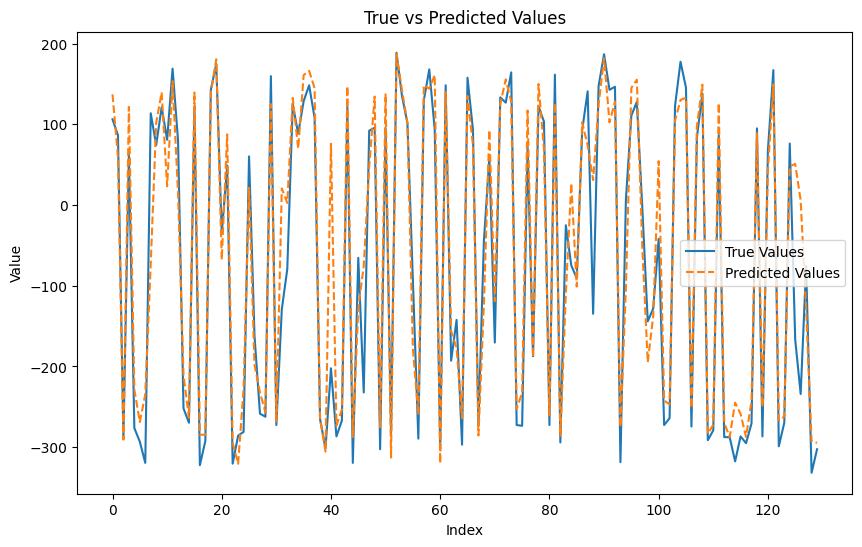

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


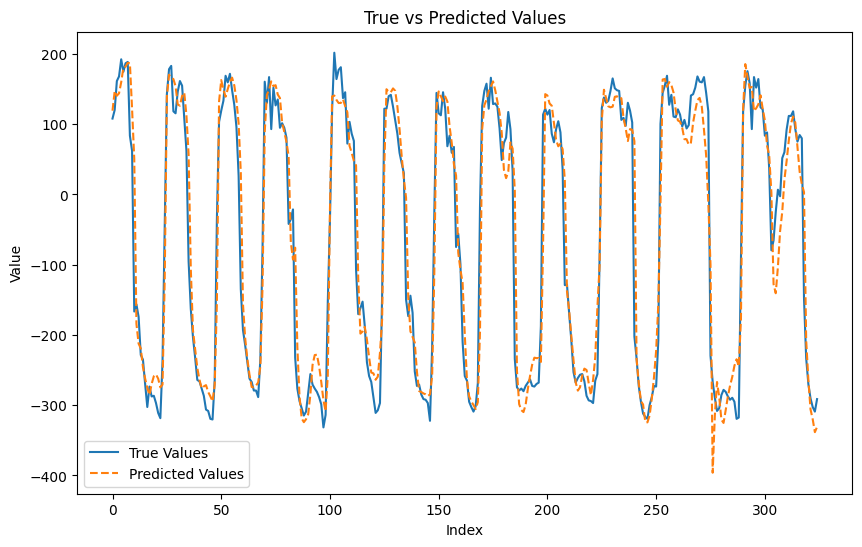

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


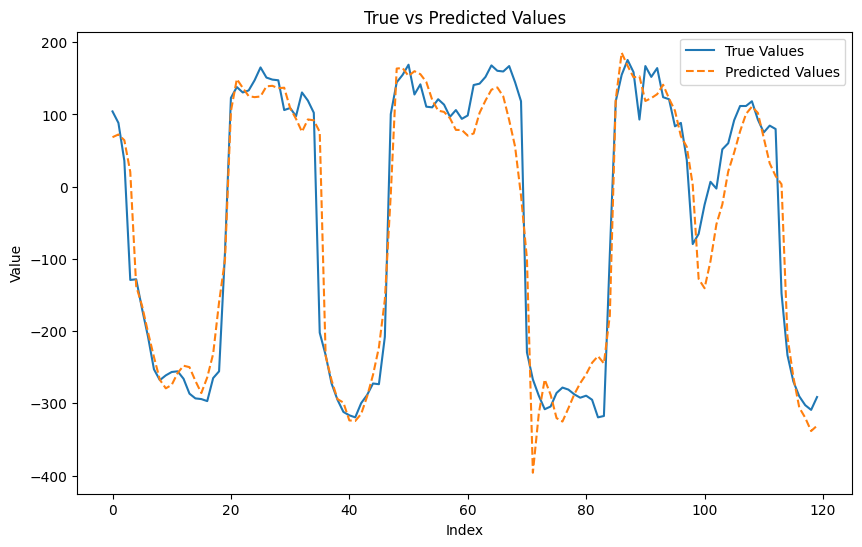

In [18]:
best_model1 = load_model(checkpoint_filepath1, custom_objects={'r_squared': r_squared})
y_test_pred1 = plot_true_vs_predicted(best_model1, x_test, y_test, target_scaler)
y_pred1 = plot_true_vs_predicted(best_model1, X, y, target_scaler)
y_final_pred1 = plot_true_vs_predicted(best_model1, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final1 = target_scaler.inverse_transform(y_final_pred1.reshape(-1, 1))
inverse_scaled_y_Predict1 = target_scaler.inverse_transform(y_pred1.reshape(-1, 1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 614ms/step


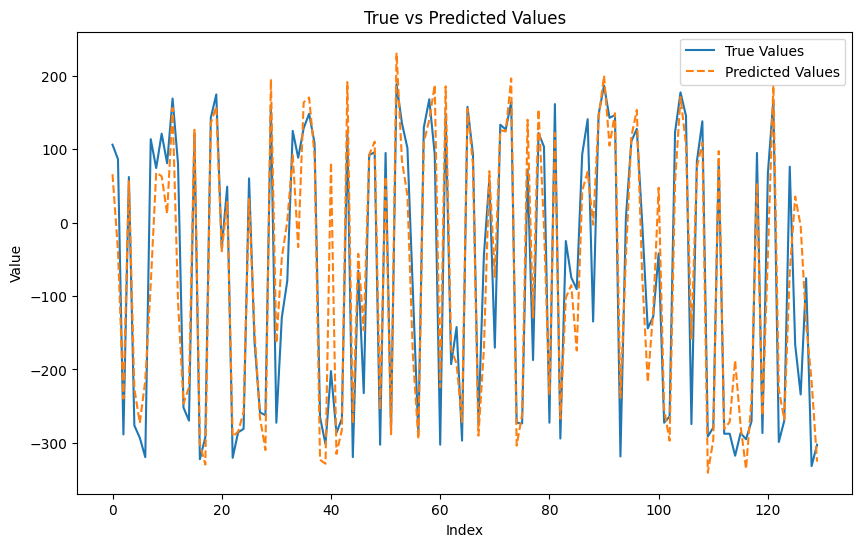

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


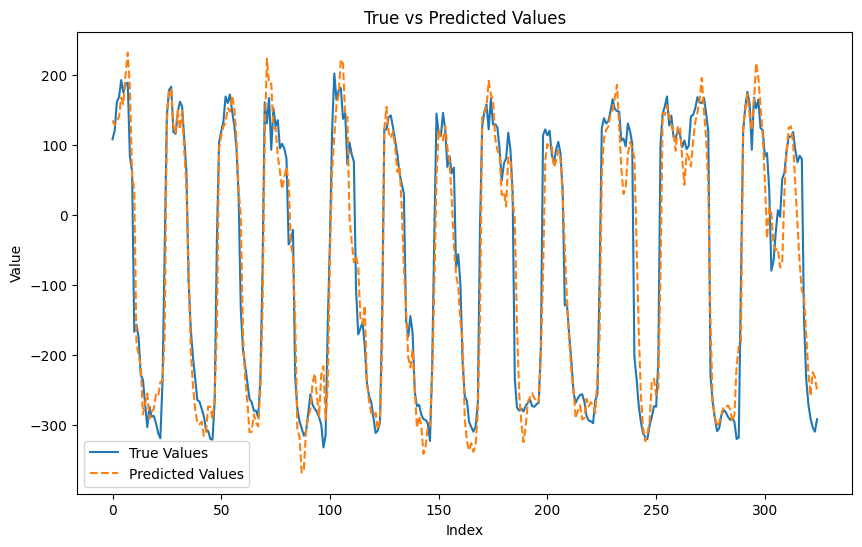

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


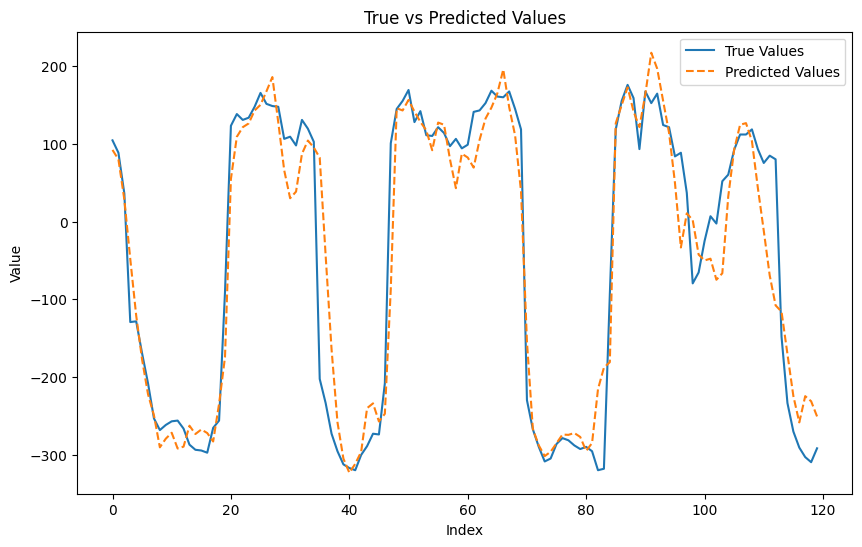

In [19]:
model.save('best_model_transformer.keras')

best_model2 = load_model('best_model_transformer.keras', custom_objects={'r_squared': r_squared})
## best_model2 = load_model(checkpoint_filepath2, custom_objects={'r_squared': r_squared})
y_test_pred2 = plot_true_vs_predicted(best_model2, x_test, y_test, target_scaler)
y_pred2 = plot_true_vs_predicted(best_model2, X, y, target_scaler)
y_final_pred2 = plot_true_vs_predicted(best_model2, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final2 = target_scaler.inverse_transform(y_final_pred2.reshape(-1, 1))
inverse_scaled_y_Predict2 = target_scaler.inverse_transform(y_pred2.reshape(-1, 1))

In [20]:
# 1. Prediksi data training dan testing
y_train_pred = best_model2.predict(x_train)
y_test_pred = best_model2.predict(x_test)

# Inverse transform data training (aktual & prediksi)
inverse_scaled_y_train = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred = target_scaler.inverse_transform(y_train_pred.reshape(-1, 1))

# Inverse transform data testing (aktual & prediksi)
inverse_scaled_y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred = target_scaler.inverse_transform(y_test_pred.reshape(-1, 1))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


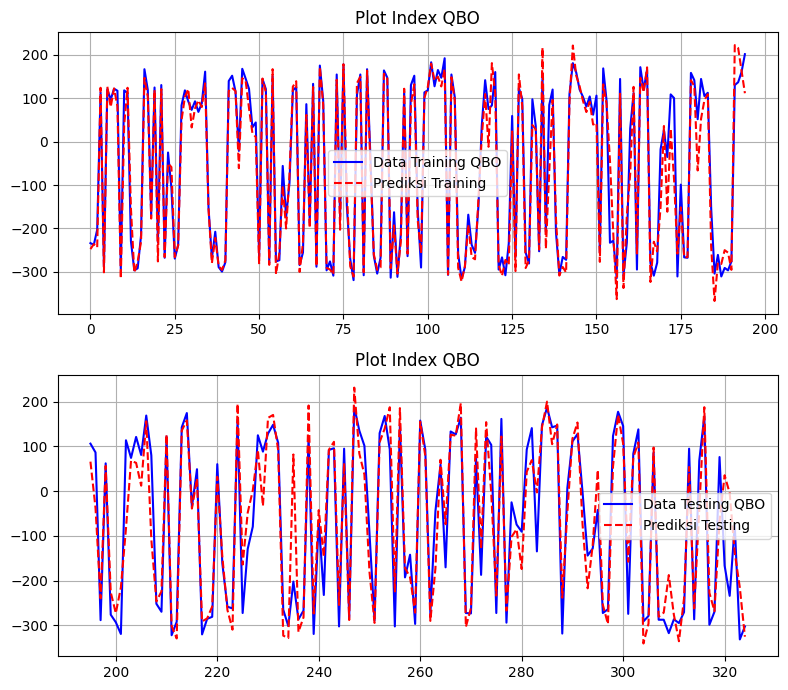

In [21]:
# Asumsikan variabel berikut sudah ada dan sudah inverse_transform:
inverse_scaled_y_train, inverse_scaled_y_train_pred
inverse_scaled_y_test, inverse_scaled_y_test_pred

# Untuk mendapatkan index global pada data test (misal setelah train 0-369, test 370-419)
train_len = len(inverse_scaled_y_train)
test_len = len(inverse_scaled_y_test)
train_idx = np.arange(train_len)
test_idx = np.arange(train_len, train_len + test_len)

plt.figure(figsize=(8, 7))

# --------- Subplot 1: Data Training ----------
plt.subplot(2, 1, 1)
plt.plot(train_idx, inverse_scaled_y_train, 'b-', label='Data Training QBO')
plt.plot(train_idx, inverse_scaled_y_train_pred, 'r--', label='Prediksi Training')
plt.title('Plot Index QBO')
plt.legend()
plt.grid(True)

# --------- Subplot 2: Data Testing ----------
plt.subplot(2, 1, 2)
plt.plot(test_idx, inverse_scaled_y_test, 'b-', label='Data Testing QBO')
plt.plot(test_idx, inverse_scaled_y_test_pred, 'r--', label='Prediksi Testing')
plt.title('Plot Index QBO')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
def r_squared(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

In [23]:
def calculate_metrics_and_print(original_data, predictions):
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(original_data, predictions)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # R-squared (R2)
    r2 = r2_score(original_data, predictions)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(original_data, predictions)

    # Log Likelihood
    residuals = original_data - predictions
    log_likelihood = np.sum(norm.logpdf(residuals))

    # Mean Absolute Percentage Error (MAPE)
    ape = np.abs((original_data - predictions) / original_data)
    mape = np.mean(ape) * 100

    # Print the metrics
    print("Metrics for Original Data Model:")
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("R-squared: ", r2)
    print("MAE: ", mae)
    print("Log Likelihood: ", log_likelihood)
    print("MAPE: ", mape)

In [24]:
calculate_metrics_and_print(y, y_pred1)

Metrics for Original Data Model:
MSE:  0.07809216206847616
RMSE:  0.27944974873575423
R-squared:  0.9220119749137808
MAE:  0.1894565081720568
Log Likelihood:  -199839.5273194158
MAPE:  171.11773647955778


In [25]:
calculate_metrics_and_print(y, y_pred2)

Metrics for Original Data Model:
MSE:  0.08404743536504981
RMSE:  0.2899093571533175
R-squared:  0.9160646430568241
MAE:  0.1930224046697371
Log Likelihood:  -199523.63846514578
MAPE:  170.5185909772535


In [26]:
calculate_metrics_and_print(y_test,y_test_pred1)

Metrics for Original Data Model:
MSE:  0.10138366914515815
RMSE:  0.31840802305400245
R-squared:  0.8966580416682155
MAE:  0.20907818682278267
Log Likelihood:  -31434.555713942358
MAPE:  205.38637593273847


In [27]:
calculate_metrics_and_print(y_test,y_test_pred2)

Metrics for Original Data Model:
MSE:  0.13591706896382422
RMSE:  0.36866932197271884
R-squared:  0.8614576075627403
MAE:  0.2611210157584803
Log Likelihood:  -31137.001790926155
MAPE:  200.8206741679739


In [28]:
inverse_scaled_target = target_scaler.inverse_transform(y.reshape(-1, 1))
inverse_scaled_y_final = target_scaler.inverse_transform(y_final.reshape(-1, 1))

In [29]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict1)

Metrics for Original Data Model:
MSE:  2779.115631479537
RMSE:  52.71731813625895
R-squared:  0.9220119743709014
MAE:  35.740375763040255
Log Likelihood:  -451904.94513871626
MAPE:  44.75126943703856


In [30]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict2)

Metrics for Original Data Model:
MSE:  2991.0497550075015
RMSE:  54.690490535444106
R-squared:  0.9160646421799842
MAE:  36.41307124232832
Log Likelihood:  -486344.24021201057
MAPE:  43.98109514837673


In [31]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final1)

Metrics for Original Data Model:
MSE:  2885.454257264296
RMSE:  53.71642446462996
R-squared:  0.92047832752309
MAE:  35.71483651980957
Log Likelihood:  -173237.52805984233
MAPE:  57.58130557501266


In [32]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final2)

Metrics for Original Data Model:
MSE:  3524.4258038727226
RMSE:  59.366874634536074
R-squared:  0.9028685920980567
MAE:  38.124291817929866
Log Likelihood:  -211575.82085634797
MAPE:  59.27105114163545


In [33]:
# --- LSTM ---
# Prediksi di data test (10%)
y_test_pred_lstm = best_model1.predict(x_test)
# Kembalikan ke skala asli
inverse_scaled_y_test_lstm = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred_lstm = target_scaler.inverse_transform(y_test_pred_lstm.reshape(-1, 1))
# Hitung & tampilkan metrics untuk data test (LSTM)
print("=== Metrics Test Set - LSTM ===")
calculate_metrics_and_print(inverse_scaled_y_test_lstm, inverse_scaled_y_test_pred_lstm)

# (Jika ingin juga untuk data train, gunakan ini:)
y_train_pred_lstm = best_model1.predict(x_train)
inverse_scaled_y_train_lstm = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred_lstm = target_scaler.inverse_transform(y_train_pred_lstm.reshape(-1, 1))
print("=== Metrics Train Set - LSTM ===")
calculate_metrics_and_print(inverse_scaled_y_train_lstm, inverse_scaled_y_train_pred_lstm)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
=== Metrics Test Set - LSTM ===
Metrics for Original Data Model:
MSE:  3608.0054218305436
RMSE:  60.06667480251045
R-squared:  0.8966580393176151
MAE:  39.44194433782335
Log Likelihood:  -234639.81442830196
MAPE:  60.14685306868247
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
=== Metrics Train Set - LSTM ===
Metrics for Original Data Model:
MSE:  2226.5223840582944
RMSE:  47.18604013962492
R-squared:  0.9382674051086313
MAE:  33.27266177572241
Log Likelihood:  -217265.12545965856
MAPE:  34.487546526558624


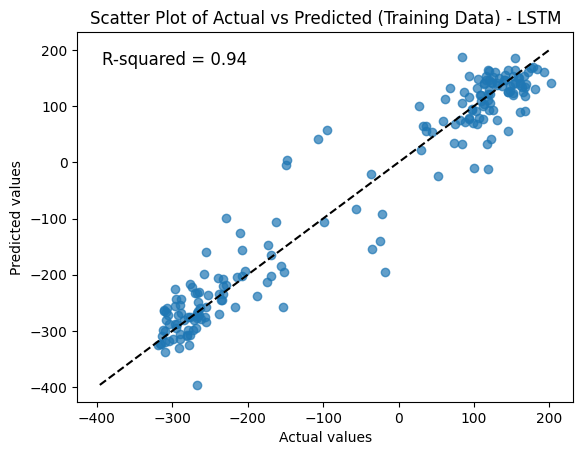

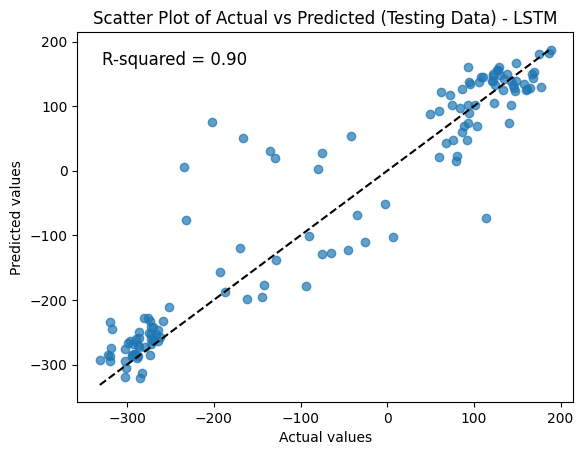

In [34]:
def plot_r2_scatter(y_true, y_pred, title, ax=None):
    r2 = r2_score(y_true, y_pred)
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, alpha=0.7)
    # Garis diagonal y=x
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')
    ax.text(0.05, 0.95, f'R-squared = {r2:.2f}', transform=ax.transAxes, 
            fontsize=12, verticalalignment='top')
    ax.set_title(title)
    ax.set_xlabel("Actual values")
    ax.set_ylabel("Predicted values")

# --- LSTM ---
# Data Training
plot_r2_scatter(
    inverse_scaled_y_train_lstm, 
    inverse_scaled_y_train_pred_lstm, 
    "Scatter Plot of Actual vs Predicted (Training Data) - LSTM"
)
plt.show()

# Data Testing
plot_r2_scatter(
    inverse_scaled_y_test_lstm, 
    inverse_scaled_y_test_pred_lstm, 
    "Scatter Plot of Actual vs Predicted (Testing Data) - LSTM"
)
plt.show()

In [35]:
# --- TRANSFORMER ---
# Prediksi di data test (10%)
y_test_pred_transformer = best_model2.predict(x_test)
# Kembalikan ke skala asli
inverse_scaled_y_test_transformer = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred_transformer = target_scaler.inverse_transform(y_test_pred_transformer.reshape(-1, 1))
# Hitung & tampilkan metrics untuk data test (Transformer)
print("=== Metrics Test Set - Transformer ===")
calculate_metrics_and_print(inverse_scaled_y_test_transformer, inverse_scaled_y_test_pred_transformer)

# (Jika ingin juga untuk data train, gunakan ini:)
y_train_pred_transformer = best_model2.predict(x_train)
inverse_scaled_y_train_transformer = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred_transformer = target_scaler.inverse_transform(y_train_pred_transformer.reshape(-1, 1))
print("=== Metrics Train Set - Transformer ===")
calculate_metrics_and_print(inverse_scaled_y_train_transformer, inverse_scaled_y_train_pred_transformer)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
=== Metrics Test Set - Transformer ===
Metrics for Original Data Model:
MSE:  4836.967548652776
RMSE:  69.54831089719416
R-squared:  0.8614576055760919
MAE:  49.259660137846154
Log Likelihood:  -314522.3526717471
MAPE:  66.98928019746647
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
=== Metrics Train Set - Transformer ===
Metrics for Original Data Model:
MSE:  1760.4378798994908
RMSE:  41.957572378528894
R-squared:  0.9511900714543142
MAE:  27.848678606191342
Log Likelihood:  -171821.88630417525
MAPE:  28.642303904639498


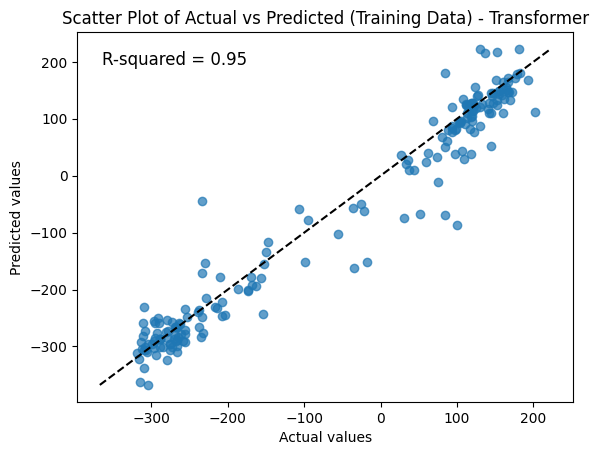

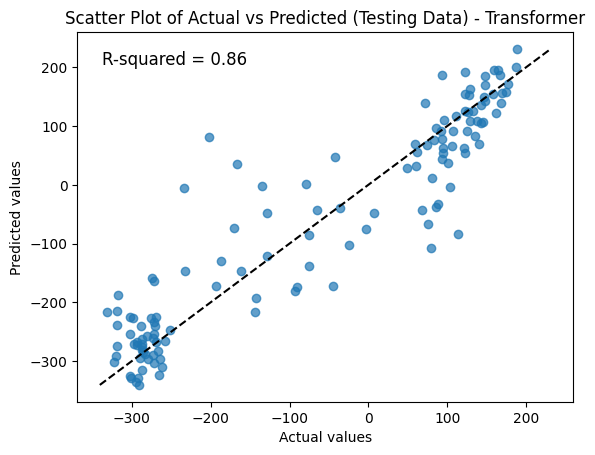

In [36]:
# --- TRANSFORMER ---
# Data Training
plot_r2_scatter(
    inverse_scaled_y_train_transformer, 
    inverse_scaled_y_train_pred_transformer, 
    "Scatter Plot of Actual vs Predicted (Training Data) - Transformer"
)
plt.show()

# Data Testing
plot_r2_scatter(
    inverse_scaled_y_test_transformer, 
    inverse_scaled_y_test_pred_transformer, 
    "Scatter Plot of Actual vs Predicted (Testing Data) - Transformer"
)
plt.show()

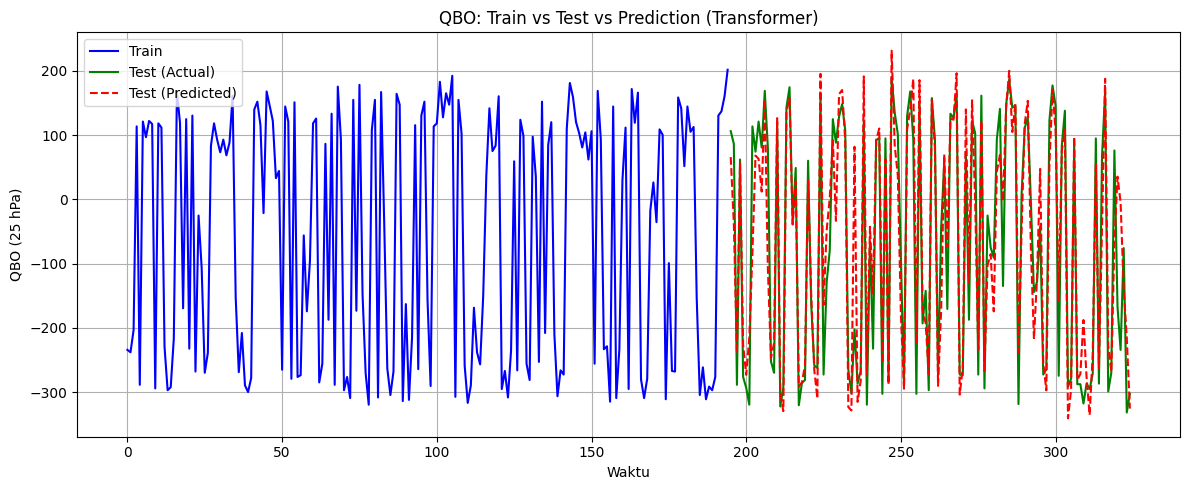

In [37]:
# Misal train_len = jumlah data train
train_len = len(inverse_scaled_y_train)
test_len = len(inverse_scaled_y_test)
train_idx = np.arange(train_len)
test_idx = np.arange(train_len, train_len + test_len)

plt.figure(figsize=(12,5))

# Plot data train (aktual)
plt.plot(train_idx, inverse_scaled_y_train, 'b-', label='Train')

# Plot data test (aktual)
plt.plot(test_idx, inverse_scaled_y_test, 'g-', label='Test (Actual)')

# Plot data test (prediksi)
plt.plot(test_idx, inverse_scaled_y_test_pred, 'r--', label='Test (Predicted)')

plt.title('QBO: Train vs Test vs Prediction (Transformer)')
plt.xlabel('Waktu')
plt.ylabel('QBO (25 hPa)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

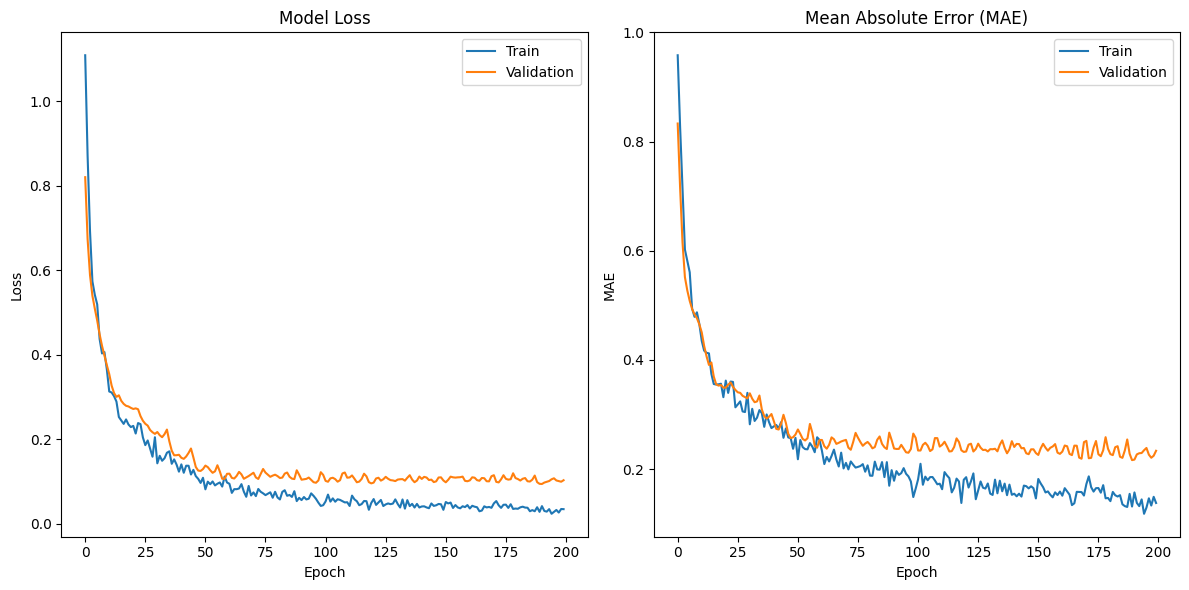

In [38]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation metrics values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Mean Absolute Error (MAE)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

In [39]:
residuals1 = inverse_scaled_target - inverse_scaled_y_Predict1
residuals_final1 = inverse_scaled_y_final - inverse_scaled_y_pred_final1

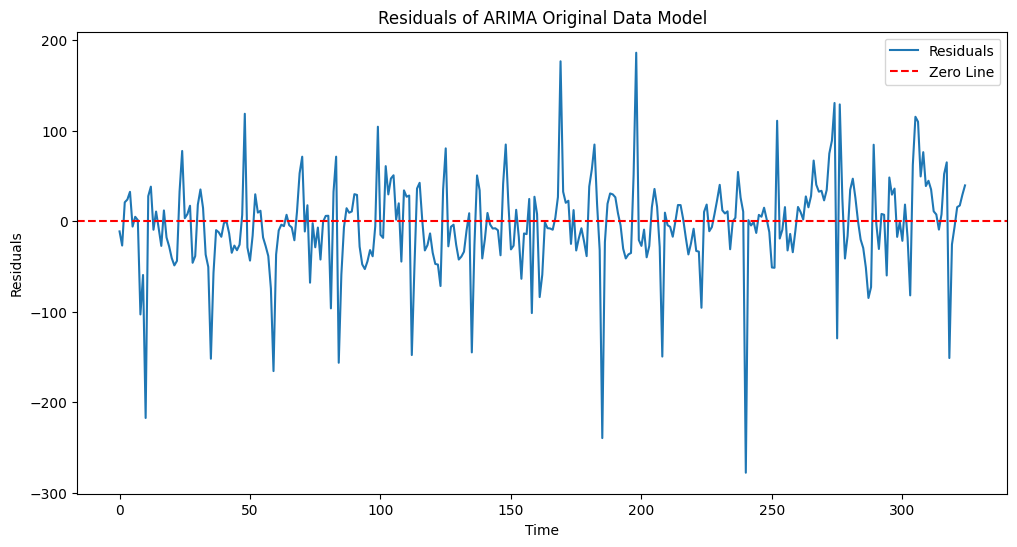

In [40]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

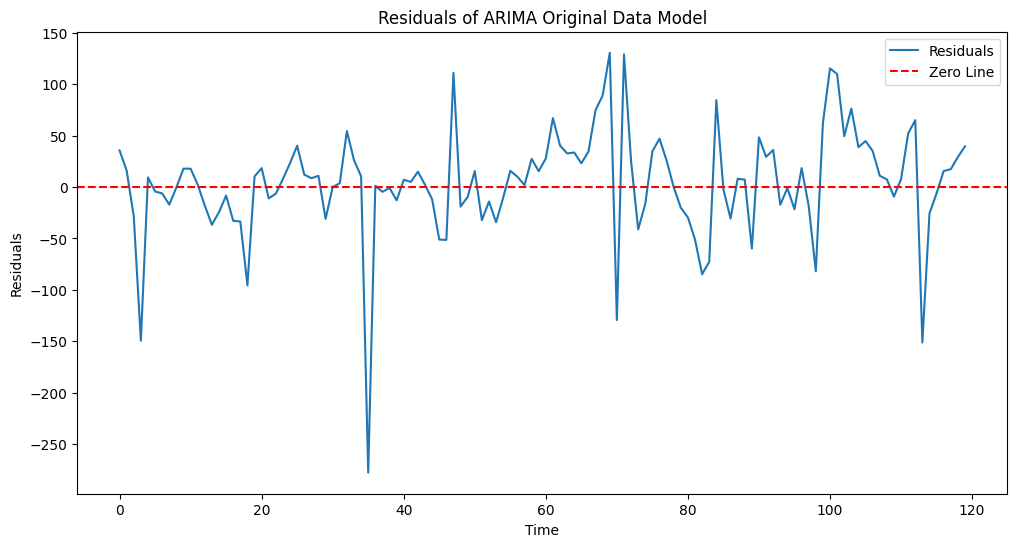

In [41]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [42]:
residuals2 = inverse_scaled_target - inverse_scaled_y_Predict2
residuals_final2 = inverse_scaled_y_final - inverse_scaled_y_pred_final2

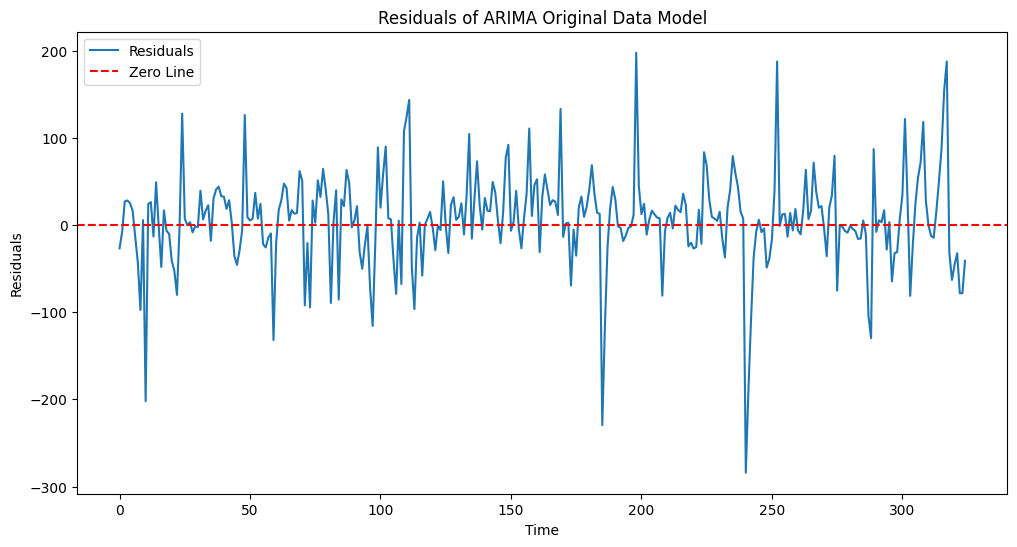

In [43]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

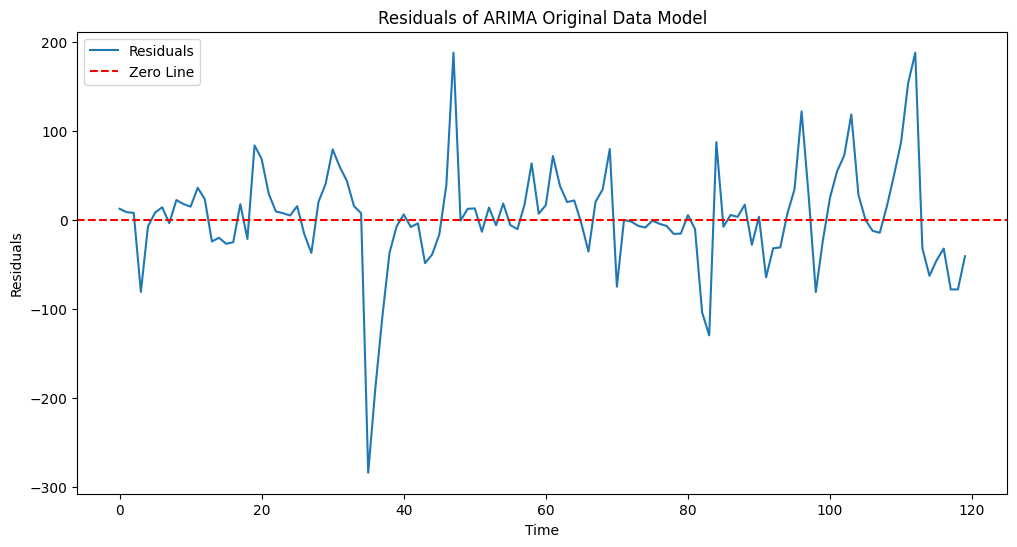

In [44]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [45]:
def residual_analysis(residuals):
    # Shapiro-Wilk Test for normality
    stat, p_value = shapiro(residuals)
    print("Shapiro-Wilk Test (Normality):")
    print("Test Statistic:", stat)
    print("P-value:", p_value)
    if p_value > 0.05:
        print("The residuals appear to be normally distributed.")
    else:
        print("The residuals may not be normally distributed.")

    # Anderson-Darling Test for normality
    result = anderson(residuals)
    test_statistic = result.statistic
    critical_values = result.critical_values

    # Plot ACF and PACF on residuals
    plt.figure(figsize=(12, 6))
    acf_res = plot_acf(residuals, title='ACF of Residuals')
    pacf_res = plot_pacf(residuals, title='PACF of Residuals')
    plt.show()

    # Plot histogram of residuals
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9113981052784224
P-value: 6.695546659024985e-13
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

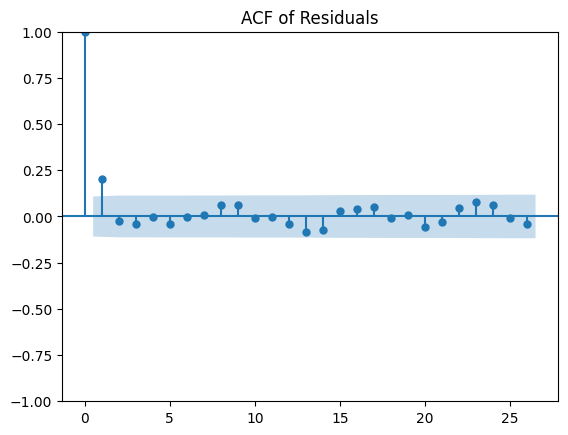

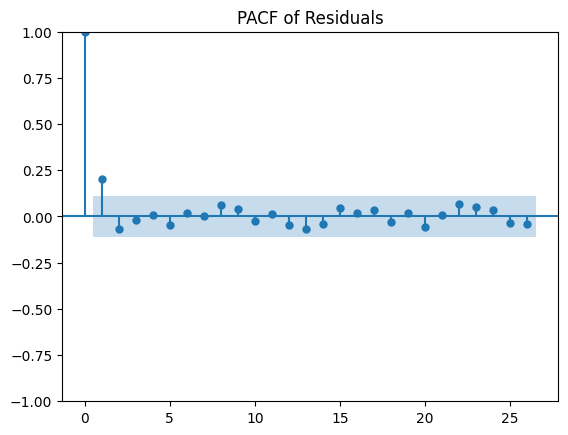

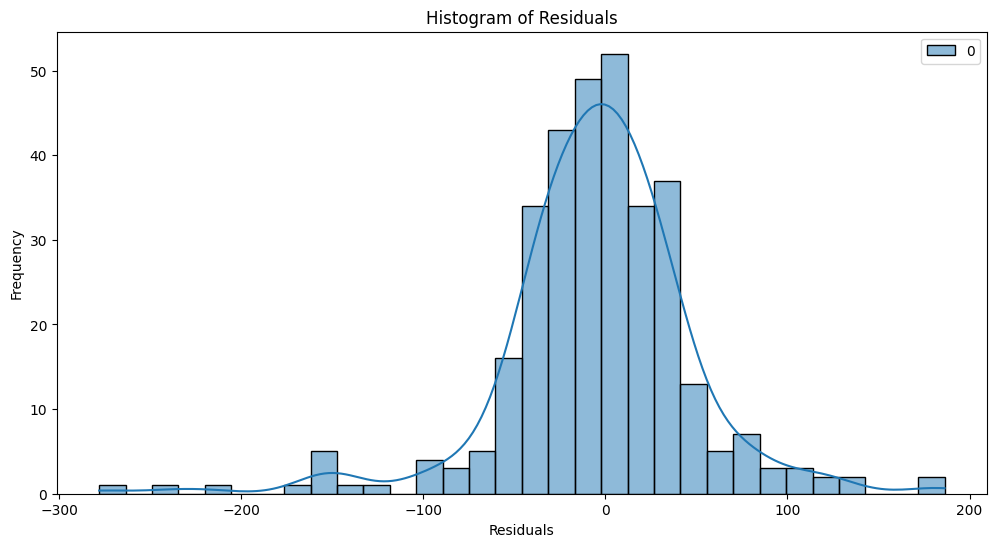

In [46]:
residual_analysis(residuals1)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.8891059529886269
P-value: 5.657029542733656e-08
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

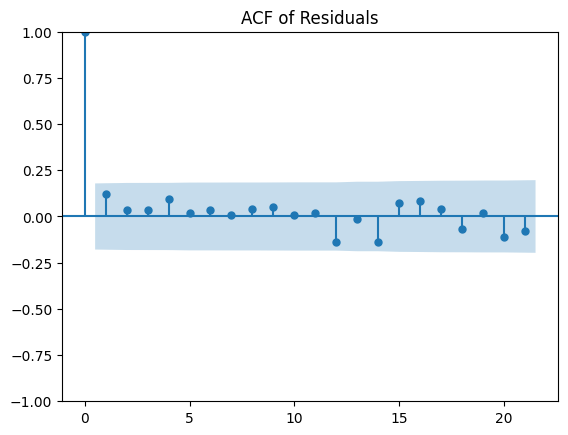

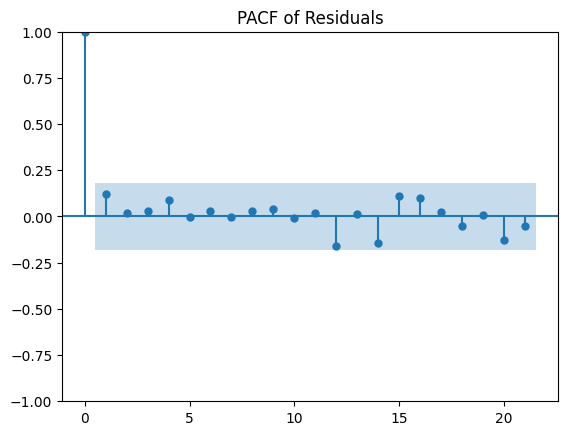

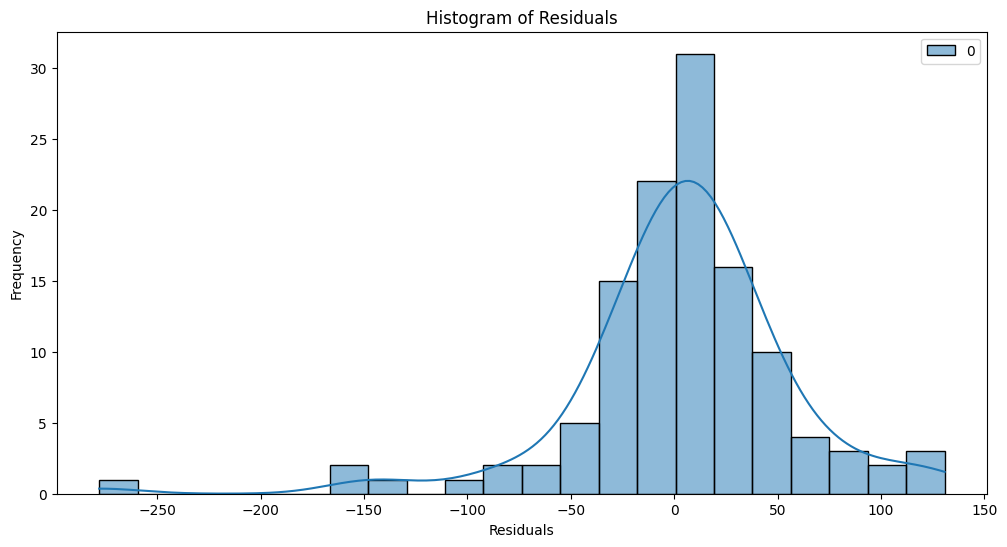

In [47]:
residual_analysis(residuals_final1)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9109466377589053
P-value: 6.140035443590631e-13
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

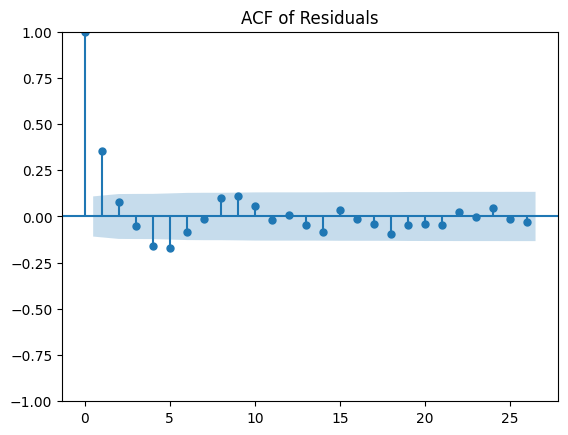

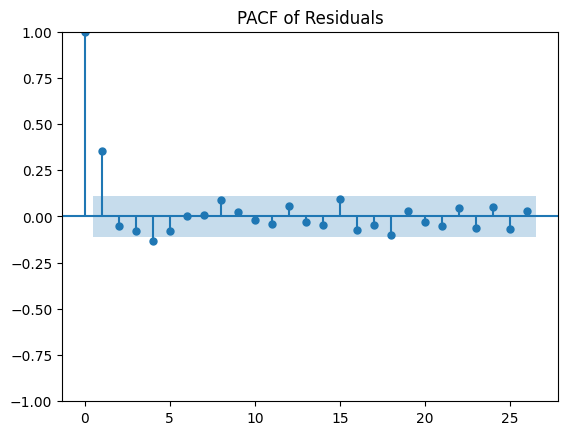

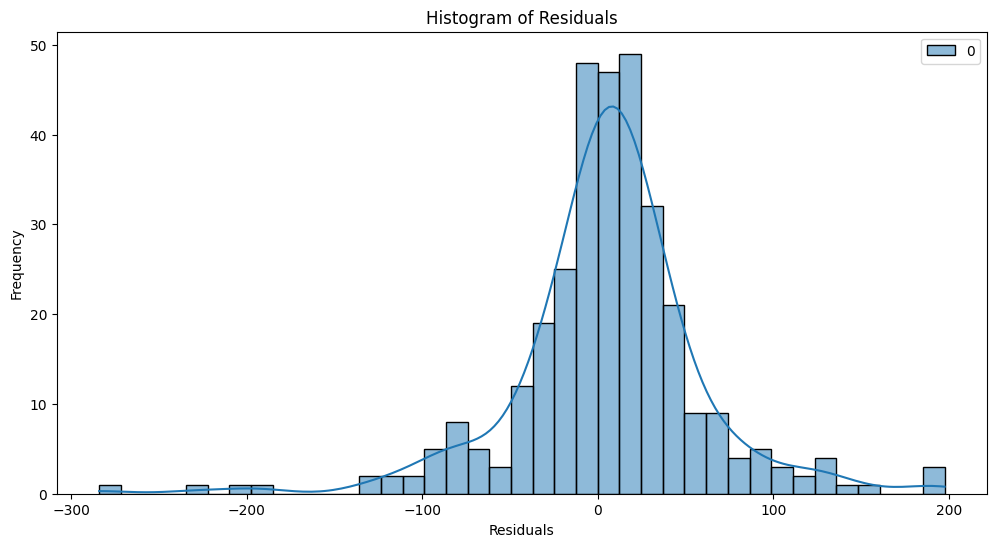

In [48]:
residual_analysis(residuals2)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.8919126772110009
P-value: 7.737771932639343e-08
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

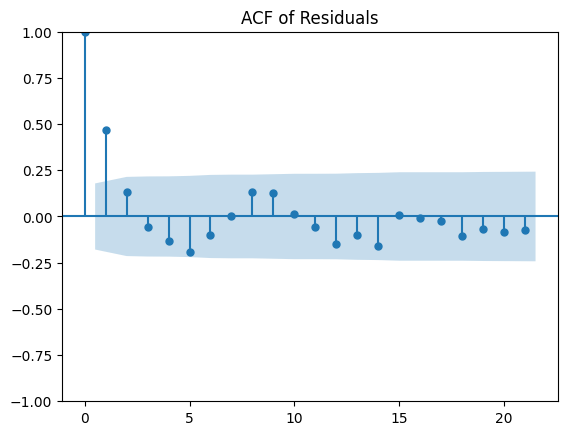

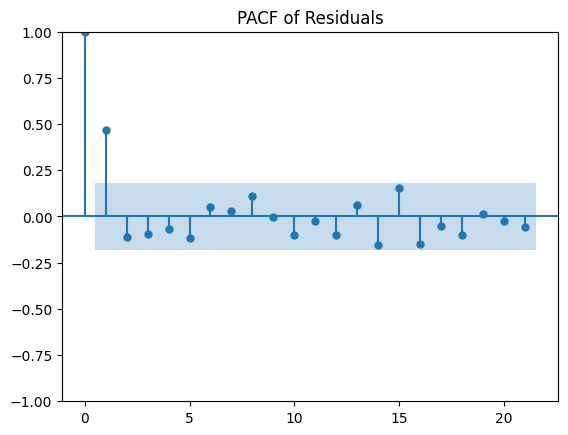

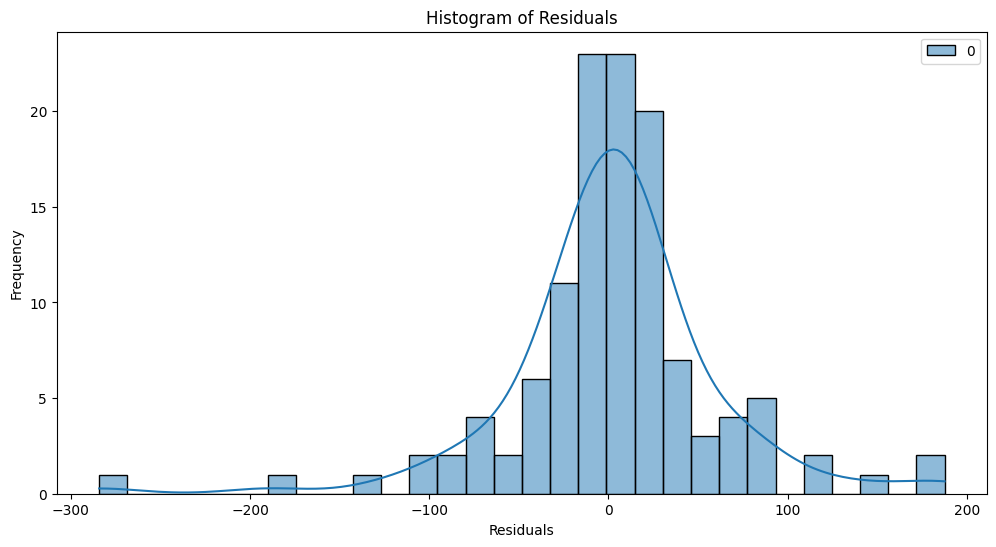

In [49]:
residual_analysis(residuals_final2)

In [50]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Load dan atur data
data_df = pd.read_excel('QBO Data.xlsx')
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%d%m%Y')
data_df.set_index('Date', inplace=True)
data_df = data_df[['25 hPa']]

In [51]:
# Fit ARIMA (bisa ubah order sesuai hasil AIC/BIC terbaik)
model_arima = ARIMA(data_df['25 hPa'], order=(4, 0, 5))  # Contoh order
model_fit = model_arima.fit()

# Prediksi in-sample
arima_pred = model_fit.fittedvalues

# Residual = aktual - prediksi
data_df['residual'] = data_df['25 hPa'] - arima_pred

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_date

In [52]:
# Gunakan residual sebagai target Transformer
target_col = 'residual'

# Tambahkan fitur seperti sebelumnya (gunakan data_df)
add_lag_features(data_df, lags)
add_rolling_statistics(data_df, window_sizes)
add_interaction_features(data_df, window_sizes)
add_seasonal_features(data_df)
add_rate_of_change(data_df, lags)
add_cumulative_sum(data_df)
add_ewma_std(data_df, window_sizes)
add_additional_statistics(data_df, window_sizes)
add_z_scores(data_df)
add_log_returns(data_df)

# Drop NaN
data_df = data_df.dropna()

# Pisahkan input dan target
X = data_df.drop(columns=['25 hPa', 'residual'])
y = data_df['residual']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tambahkan dimensi time untuk Transformer
X_train_scaled = np.expand_dims(X_train_scaled, axis=1)  # shape: (samples, time, features)
X_test_scaled = np.expand_dims(X_test_scaled, axis=1)

In [54]:
def build_transformer(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Dense(64)(inputs)
    
    attention_output = layers.MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization()(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)
    
    model = models.Model(inputs, outputs)
    return model

model = build_transformer(X_train_scaled.shape[1:])  # input shape = (time, features)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1, 78)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1, 64)     │      5,056 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 64)     │     16,640 │ dense_4[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 1, 64)     │          0 │ dense_4[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 64)     │        128 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         33 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,937 (93.50 KB)

 Trainable params: 23,937 (93.50 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Train Transformer on residuals
model.fit(X_train_scaled, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# Prediksi residual
residual_pred = model.predict(X_test_scaled).flatten()

# Prediksi ARIMA untuk periode test
arima_forecast = model_fit.predict(start=X_test.index[0], end=X_test.index[-1])

# Kombinasi: ARIMA + Transformer
final_pred = arima_forecast + residual_pred

# Evaluasi
from sklearn.metrics import mean_squared_error, r2_score
print("RMSE:", np.sqrt(mean_squared_error(y_test + arima_forecast, final_pred)))
print("R2 Score:", r2_score(y_test + arima_forecast, final_pred))

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 1928.0021 - val_loss: 1321.7798
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2129.9038 - val_loss: 1291.3069
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1653.8073 - val_loss: 1265.2318
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1945.0377 - val_loss: 1204.3008
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2301.6941 - val_loss: 1157.3413
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1600.7278 - val_loss: 1071.2097
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1767.6150 - val_loss: 1021.8870
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1629.1808 - val_loss: 977.8562
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2248.1868 - val_loss: 933.5310
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1790.2743 - val_loss: 912.5856
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1835.1776 - val_loss: 864.3921
E

ValueError: operands could not be broadcast together with shapes (76,) (71,) 